### XGBoostに色々な種類の新規データを与えて挙動を確かめる！

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
building = pd.read_csv('../data/handmade_data/building.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms, kitchen_points], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms, test_kitchen_points], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 'ガスコンロ', 'コンロ2口', 'システムキッチン', '給湯', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ']

Duplicate key in file PosixPath('/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family : IPAexGothic')


[08:46:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133020.32392	validation_1-rmse:131392.70231
[1]	validation_0-rmse:126712.05830	validation_1-rmse:125294.79813
[2]	validation_0-rmse:120838.10192	validation_1-rmse:119605.69002
[3]	validation_0-rmse:115260.94639	validation_1-rmse:114198.81509
[4]	validation_0-rmse:109895.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:82887.55157	validation_1-rmse:82964.81574
[11]	validation_0-rmse:79093.14387	validation_1-rmse:79353.83145
[12]	validation_0-rmse:75509.86381	validation_1-rmse:75942.03031
[13]	validation_0-rmse:72096.82322	validation_1-rmse:72694.25606
[14]	validation_0-rmse:68889.40010	validation_1-rmse:69644.80899
[15]	validation_0-rmse:65895.38580	validation_1-rmse:66809.48563
[16]	validation_0-rmse:63045.41250	validation_1-rmse:64156.95384
[17]	validation_0-rmse:60282.59235	validation_1-rmse:61576.29660
[18]	validation_0-rmse:57655.61741	validation_1-rmse:59104.98940
[19]	validation_0-rmse:55249.17064	validation_1-rmse:56884.29750
[20]	validation_0-rmse:53074.35288	validation_1-rmse:54776.54815
[21]	validation_0-rmse:50904.72651	validation_1-rmse:52787.21391
[22]	validation_0-rmse:48804.91428	validation_1-rmse:50863.09973
[23]	validation_0-rmse:46775.08188	validation_1-rmse:48971.03249
[24]	validation_0-rmse:44877.52402	validation_1-rmse:47221.87683
[25]	validation_0-rmse:43

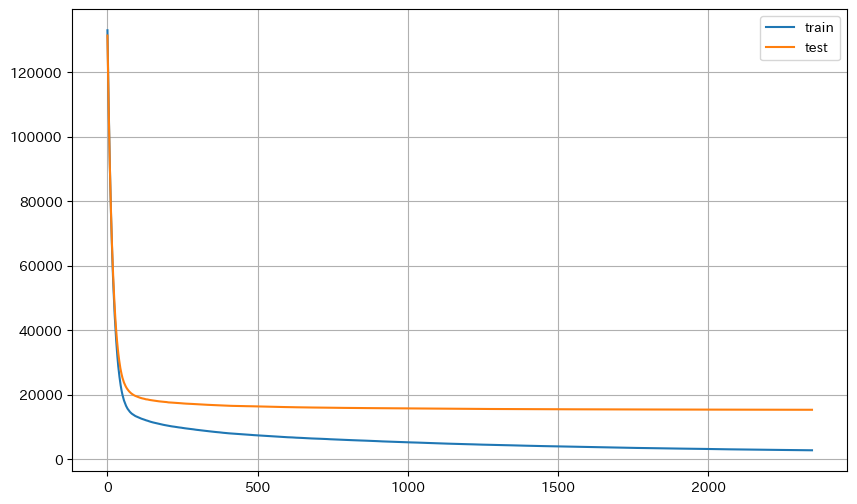

[08:47:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:47:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132768.06281	validation_1-rmse:132439.13866
[1]	validation_0-rmse:126480.40178	validation_1-rmse:126262.69927
[2]	validation_0-rmse:120621.62659	validation_1-rmse:120546.46810
[3]	validation_0-rmse:115060.61932	validation_1-rmse:115145.58221
[4]	validation_0-rmse:109712.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:99857.15514	validation_1-rmse:100349.59937
[7]	validation_0-rmse:95278.17768	validation_1-rmse:95957.67747
[8]	validation_0-rmse:90878.45212	validation_1-rmse:91745.98670
[9]	validation_0-rmse:86769.93333	validation_1-rmse:87801.31211
[10]	validation_0-rmse:82792.39781	validation_1-rmse:83997.41227
[11]	validation_0-rmse:79013.76343	validation_1-rmse:80293.75374
[12]	validation_0-rmse:75441.96391	validation_1-rmse:76860.07788
[13]	validation_0-rmse:72041.04135	validation_1-rmse:73575.33736
[14]	validation_0-rmse:68857.65376	validation_1-rmse:70437.87148
[15]	validation_0-rmse:65878.54751	validation_1-rmse:67561.20039
[16]	validation_0-rmse:63030.74428	validation_1-rmse:64883.37609
[17]	validation_0-rmse:60282.57306	validation_1-rmse:62225.47374
[18]	validation_0-rmse:57662.51510	validation_1-rmse:59712.45144
[19]	validation_0-rmse:55266.41196	validation_1-rmse:57415.77249
[20]	validation_0-rmse:53100.05334	validation_1-rmse:55407.76680
[21]	validation_0-rmse:50947

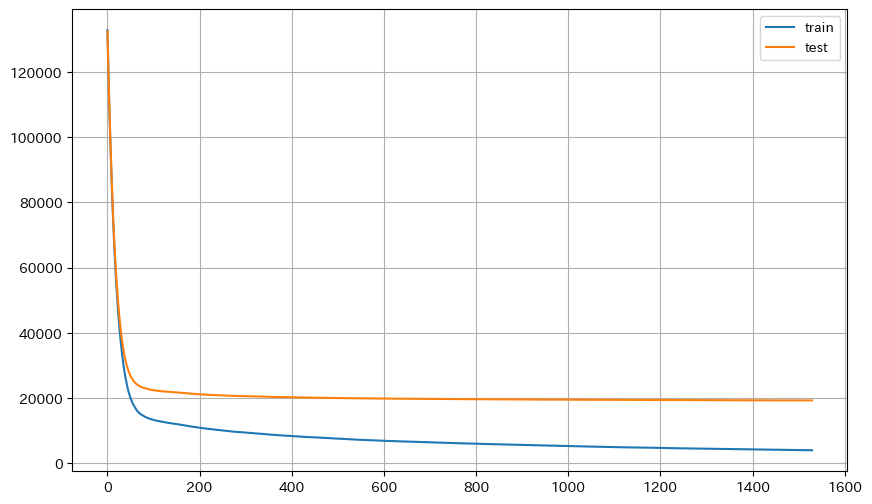

[08:47:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:47:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132319.40829	validation_1-rmse:134103.16321
[1]	validation_0-rmse:126071.50540	validation_1-rmse:127753.11824
[2]	validation_0-rmse:120236.89975	validation_1-rmse:121776.60978
[3]	validation_0-rmse:114705.07080	validation_1-rmse:116086.80264
[4]	validation_0-rmse:109377.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:99584.86968	validation_1-rmse:100902.72236
[7]	validation_0-rmse:95049.64803	validation_1-rmse:96271.80769
[8]	validation_0-rmse:90671.94105	validation_1-rmse:91835.63476
[9]	validation_0-rmse:86579.77412	validation_1-rmse:87724.35836
[10]	validation_0-rmse:82618.73127	validation_1-rmse:83698.99013
[11]	validation_0-rmse:78866.61062	validation_1-rmse:79927.46482
[12]	validation_0-rmse:75313.39493	validation_1-rmse:76342.29052
[13]	validation_0-rmse:71928.77169	validation_1-rmse:72916.69632
[14]	validation_0-rmse:68751.94540	validation_1-rmse:69723.12101
[15]	validation_0-rmse:65806.29228	validation_1-rmse:66794.18875
[16]	validation_0-rmse:62978.47576	validation_1-rmse:63883.07019
[17]	validation_0-rmse:60238.20726	validation_1-rmse:61136.33683
[18]	validation_0-rmse:57642.80340	validation_1-rmse:58578.16587
[19]	validation_0-rmse:55252.46398	validation_1-rmse:56194.11304
[20]	validation_0-rmse:53096.79462	validation_1-rmse:54130.98032
[21]	validation_0-rmse:50955

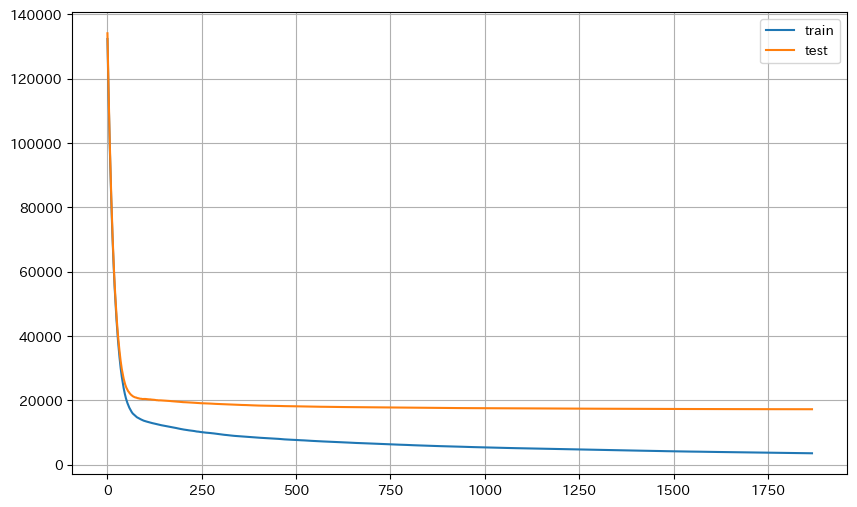

[08:48:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132983.37926	validation_1-rmse:131375.54005
[1]	validation_0-rmse:126680.31309	validation_1-rmse:125173.83140
[2]	validation_0-rmse:120822.79963	validation_1-rmse:119377.26756
[3]	validation_0-rmse:115267.87173	validation_1-rmse:113893.03037
[4]	validation_0-rmse:109908.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:95465.62825	validation_1-rmse:94546.85989
[8]	validation_0-rmse:91046.00417	validation_1-rmse:90235.01613
[9]	validation_0-rmse:86935.53692	validation_1-rmse:86190.66353
[10]	validation_0-rmse:82936.87944	validation_1-rmse:82299.64619
[11]	validation_0-rmse:79150.84268	validation_1-rmse:78629.67401
[12]	validation_0-rmse:75561.17473	validation_1-rmse:75152.57401
[13]	validation_0-rmse:72146.35237	validation_1-rmse:71830.46997
[14]	validation_0-rmse:68943.38947	validation_1-rmse:68790.24490
[15]	validation_0-rmse:65950.50992	validation_1-rmse:65942.29928
[16]	validation_0-rmse:63095.26413	validation_1-rmse:63213.27765
[17]	validation_0-rmse:60331.78337	validation_1-rmse:60558.57640
[18]	validation_0-rmse:57707.70668	validation_1-rmse:58083.69712
[19]	validation_0-rmse:55299.09298	validation_1-rmse:55817.10746
[20]	validation_0-rmse:53139.15000	validation_1-rmse:53784.65267
[21]	validation_0-rmse:50974.21381	validation_1-rmse:51774.48183
[22]	validation_0-rmse:48881

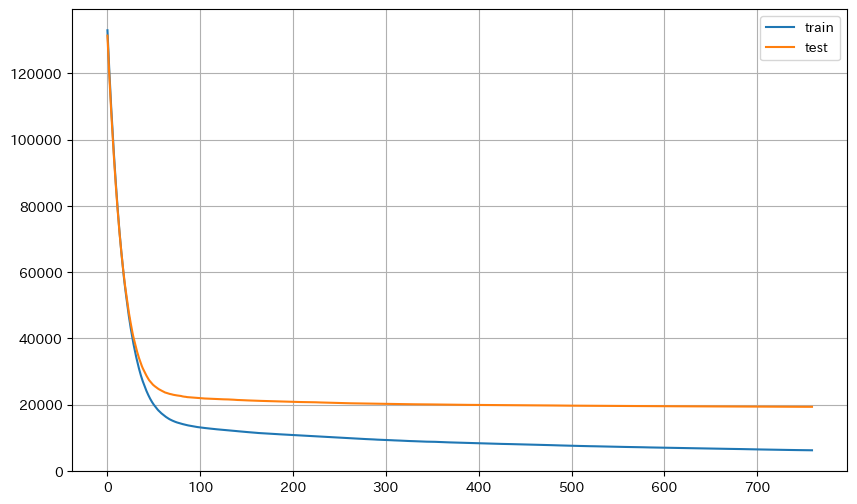

[08:48:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132274.44382	validation_1-rmse:134390.79312
[1]	validation_0-rmse:126013.49731	validation_1-rmse:128130.45079
[2]	validation_0-rmse:120199.00811	validation_1-rmse:122382.77157
[3]	validation_0-rmse:114684.54337	validation_1-rmse:116955.77925
[4]	validation_0-rmse:109370.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:95016.50435	validation_1-rmse:97256.18543
[8]	validation_0-rmse:90646.12597	validation_1-rmse:92874.02413
[9]	validation_0-rmse:86567.71032	validation_1-rmse:88827.34986
[10]	validation_0-rmse:82616.32537	validation_1-rmse:84910.74012
[11]	validation_0-rmse:78856.89573	validation_1-rmse:81108.95548
[12]	validation_0-rmse:75314.26885	validation_1-rmse:77649.51232
[13]	validation_0-rmse:71939.07217	validation_1-rmse:74219.49524
[14]	validation_0-rmse:68774.07899	validation_1-rmse:71066.06664
[15]	validation_0-rmse:65829.25152	validation_1-rmse:68205.41424
[16]	validation_0-rmse:63000.52789	validation_1-rmse:65344.17006
[17]	validation_0-rmse:60260.15762	validation_1-rmse:62662.01347
[18]	validation_0-rmse:57664.34074	validation_1-rmse:60032.56093
[19]	validation_0-rmse:55294.04152	validation_1-rmse:57786.91764
[20]	validation_0-rmse:53161.38279	validation_1-rmse:55787.76305
[21]	validation_0-rmse:51032.36112	validation_1-rmse:53745.67956
[22]	validation_0-rmse:48970

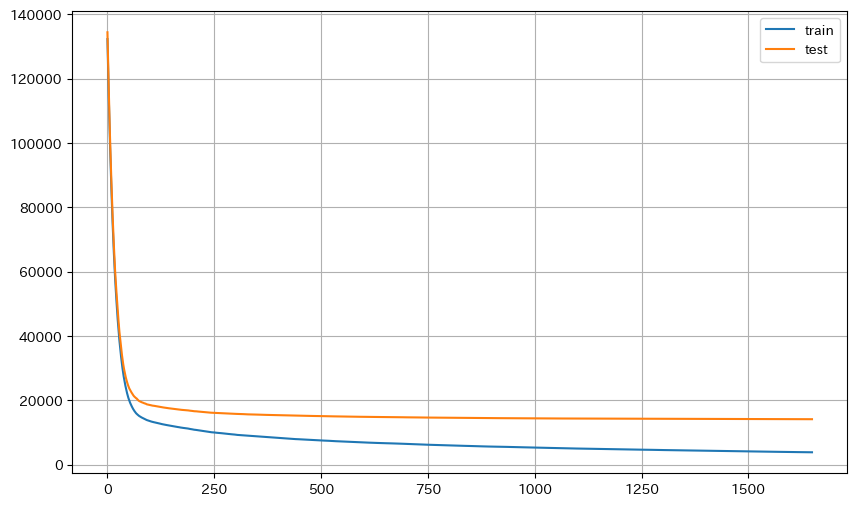

whole valid rmse: 17073.972798383416
Start predicting...


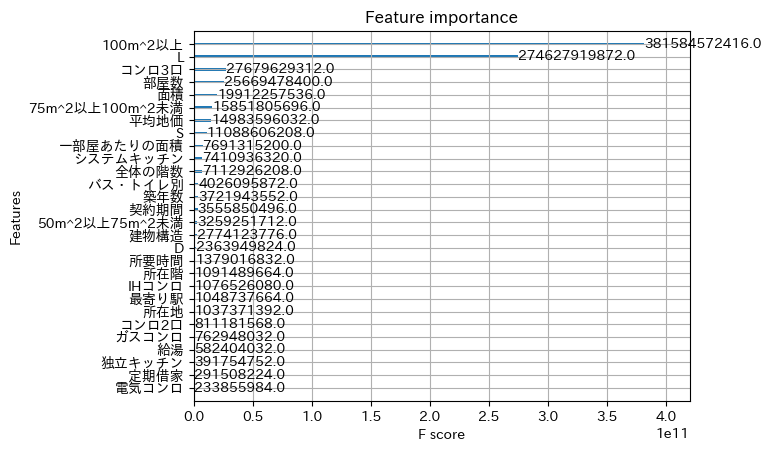

In [2]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    # 学習時に用いる検証用データ
    evals = [(X_tr, 'train'), (X_tr, 'eval')]
    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        # 回帰問題
                        objective='reg:linear',
                        # 学習用の指標 (RMSE)
                        eval_metric='rmse',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        #学習率
                        learning_rate=0.05,
                        #木の最大深さ
                        max_depth=7,
                        #シード値
                        random_state=0,
                            #正則化
                        reg_alfa=6.8594164113286965e-06,

                        sub_sample=0.16056047423047484,

                        colsample_bytree=0.6987351856651322,

                        min_child_weight=1.1103525577197584,
                        
                        evals=evals,

                        evals_result=evals_result
    )
    xgb_reg.fit(X_tr, y_tr, 
                eval_set=[(X_tr, y_tr),(X_val, y_val)], 
                early_stopping_rounds=10, 
            )
    evals_result = xgb_reg.evals_result()
    train_evals = evals_result['validation_0']['rmse']
    test_evals = evals_result['validation_1']['rmse']

    pred_y_val = xgb_reg.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

    # 学習の課程を折れ線グラフとしてプロットする
    print('Plot metrics during training...')
    plt.figure(figsize=(10, 6))
    plt.subplot(111)
    x = range(len(train_evals))
    plt.plot(x, train_evals, label='train')
    plt.plot(x, test_evals, label='test')
    # plt.plot(x, ave_cv_evals, label='validation')
    plt.grid()
    plt.legend()
    plt.show()

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = xgb_reg.predict(X_test)

# feature importanceを表示
xgboost.plot_importance(xgb_reg, importance_type = "gain")
plt.show()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
# sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
# sepa_bath_toilets.columns = ['バス・トイレ別']
# washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
# kitchen_points.drop(['ガスコンロ'],axis=1,inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
# bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
parkings = pd.read_csv('../data/handmade_data/parkings.csv')
# parkings.drop('',axis=1,inplace=True)
building = pd.read_csv('../data/handmade_data/building.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
# test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
# test_sepa_bath_toilets.columns = ['バス・トイレ別']
# test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
# test_kitchen_points.drop(['ガスコンロ'],axis=1,inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
# test_bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
test_broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
test_parkings = pd.read_csv('../data/test_data/test_parkings.csv')
# test_parkings.drop('',axis=1,inplace=True)
test_building = pd.read_csv('../data/test_data/test_building.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, 
                    stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], 
                    building, buildings,over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
                    kitchen_points, equipments, bath_toilet_points, broadcasts, parkings], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, 
                    test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
                    test_building, test_buildings,test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
                     test_kitchen_points, test_equipments, test_bath_toilet_points, test_broadcasts, test_parkings], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S','カテゴリ建物構造','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
                    'ガスコンロ', 'コンロ2口', '給湯','システムキッチン', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ',
                    'エアコン付','シューズボックス','バルコニー','室内洗濯機置場',
                    '敷地内ごみ置き場','エレベーター','水道その他','都市ガス','タイル張',
                    'ウォークインクローゼット','2面採光','3面採光','24時間換気システム','クッションフロア','庭','床暖房','ロフト',
                    '出窓','トランクルーム','オール電化',
                    '専用バス','バス・トイレ別','シャワー','専用トイレ','浴室乾燥機','温水洗浄便座',
                    '洗面台独立','脱衣所','追焚機能',
                    'インターネット対応','catv','csアンテナ','bsアンテナ','光ファイバー',
                    'インターネット使用料無料',
                    '駐車場空有','駐車場空無','駐車場無','駐車場近隣',
                    '駐輪場空有','駐輪場無','バイク置き場無','バイク置き場空有'
                    ]

[08:51:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133010.49508	validation_1-rmse:131397.85975
[1]	validation_0-rmse:127054.43350	validation_1-rmse:125574.13464
[2]	validation_0-rmse:121103.11788	validation_1-rmse:119880.11745
[3]	validation_0-rmse:115536.76925	validation_1-rmse:114509.29481
[4]	validation_0-rmse:110088.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:91505.91972	validation_1-rmse:91379.85220
[9]	validation_0-rmse:87389.08169	validation_1-rmse:87443.58808
[10]	validation_0-rmse:83362.06625	validation_1-rmse:83574.13083
[11]	validation_0-rmse:79540.82416	validation_1-rmse:79938.96900
[12]	validation_0-rmse:75918.27606	validation_1-rmse:76497.02598
[13]	validation_0-rmse:72480.32176	validation_1-rmse:73233.04277
[14]	validation_0-rmse:69303.57946	validation_1-rmse:70267.90030
[15]	validation_0-rmse:66204.23526	validation_1-rmse:67362.48198
[16]	validation_0-rmse:63254.23019	validation_1-rmse:64544.32369
[17]	validation_0-rmse:60466.37780	validation_1-rmse:61934.81289
[18]	validation_0-rmse:57839.51861	validation_1-rmse:59466.81462
[19]	validation_0-rmse:55338.24914	validation_1-rmse:57081.41938
[20]	validation_0-rmse:52980.50416	validation_1-rmse:54881.86721
[21]	validation_0-rmse:50774.34168	validation_1-rmse:52866.11078
[22]	validation_0-rmse:48643.20858	validation_1-rmse:50863.21010
[23]	validation_0-rmse:4668

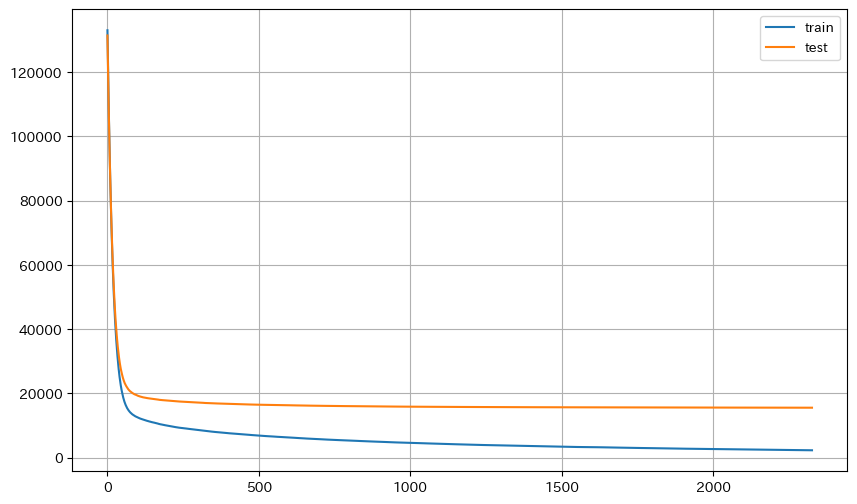

[08:52:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132775.21032	validation_1-rmse:132456.17334
[1]	validation_0-rmse:126839.90206	validation_1-rmse:126686.61309
[2]	validation_0-rmse:120916.65746	validation_1-rmse:120853.18205
[3]	validation_0-rmse:115362.18976	validation_1-rmse:115442.09753
[4]	validation_0-rmse:109932.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:100308.19399	validation_1-rmse:100930.26295
[7]	validation_0-rmse:95670.75952	validation_1-rmse:96358.09872
[8]	validation_0-rmse:91383.70569	validation_1-rmse:92138.23887
[9]	validation_0-rmse:87278.40926	validation_1-rmse:88222.21795
[10]	validation_0-rmse:83272.82982	validation_1-rmse:84283.58225
[11]	validation_0-rmse:79470.47071	validation_1-rmse:80624.99056
[12]	validation_0-rmse:75865.51830	validation_1-rmse:77106.18241
[13]	validation_0-rmse:72448.75631	validation_1-rmse:73702.59234
[14]	validation_0-rmse:69272.58944	validation_1-rmse:70693.10770
[15]	validation_0-rmse:66174.73832	validation_1-rmse:67656.94808
[16]	validation_0-rmse:63247.06374	validation_1-rmse:64847.92250
[17]	validation_0-rmse:60463.65487	validation_1-rmse:62141.00033
[18]	validation_0-rmse:57843.61423	validation_1-rmse:59638.85816
[19]	validation_0-rmse:55360.66843	validation_1-rmse:57271.61055
[20]	validation_0-rmse:53008.72754	validation_1-rmse:55051.04298
[21]	validation_0-rmse:5080

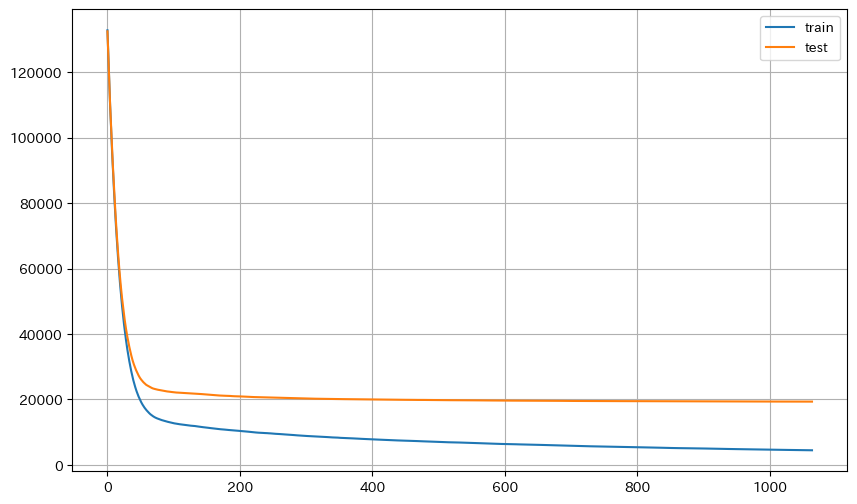

[08:53:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132318.50461	validation_1-rmse:134091.51071
[1]	validation_0-rmse:126384.80175	validation_1-rmse:128248.04621
[2]	validation_0-rmse:120479.52707	validation_1-rmse:122208.22128
[3]	validation_0-rmse:114943.37210	validation_1-rmse:116716.84342
[4]	validation_0-rmse:109541.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:104718.43829	validation_1-rmse:106396.78025
[6]	validation_0-rmse:99970.25579	validation_1-rmse:101512.86951
[7]	validation_0-rmse:95345.87993	validation_1-rmse:96822.71737
[8]	validation_0-rmse:91091.55044	validation_1-rmse:92620.83247
[9]	validation_0-rmse:87022.62101	validation_1-rmse:88510.61488
[10]	validation_0-rmse:83031.45072	validation_1-rmse:84540.38209
[11]	validation_0-rmse:79243.60445	validation_1-rmse:80746.17331
[12]	validation_0-rmse:75645.17997	validation_1-rmse:77169.61645
[13]	validation_0-rmse:72229.28482	validation_1-rmse:73743.12571
[14]	validation_0-rmse:69067.54400	validation_1-rmse:70538.64154
[15]	validation_0-rmse:65993.09898	validation_1-rmse:67448.73936
[16]	validation_0-rmse:63077.06776	validation_1-rmse:64482.62397
[17]	validation_0-rmse:60303.49312	validation_1-rmse:61694.07409
[18]	validation_0-rmse:57698.37142	validation_1-rmse:59063.71199
[19]	validation_0-rmse:55228.55540	validation_1-rmse:56573.25739
[20]	validation_0-rmse:5288

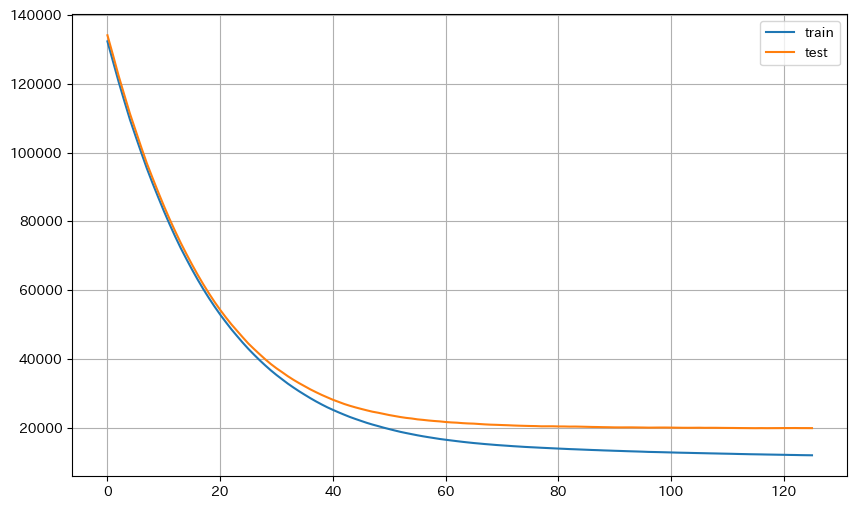

[08:53:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133001.21209	validation_1-rmse:131387.13194
[1]	validation_0-rmse:127064.52044	validation_1-rmse:125581.80552
[2]	validation_0-rmse:121125.85903	validation_1-rmse:119734.60129
[3]	validation_0-rmse:115560.82958	validation_1-rmse:114231.51352
[4]	validation_0-rmse:110116.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:105287.70641	validation_1-rmse:104179.47436
[6]	validation_0-rmse:100509.23181	validation_1-rmse:99474.75656
[7]	validation_0-rmse:95843.49101	validation_1-rmse:94933.26605
[8]	validation_0-rmse:91555.42185	validation_1-rmse:90802.95517
[9]	validation_0-rmse:87434.23358	validation_1-rmse:86807.94832
[10]	validation_0-rmse:83402.59772	validation_1-rmse:82889.19604
[11]	validation_0-rmse:79581.26714	validation_1-rmse:79216.02951
[12]	validation_0-rmse:75956.94350	validation_1-rmse:75708.82851
[13]	validation_0-rmse:72511.66934	validation_1-rmse:72434.21327
[14]	validation_0-rmse:69333.70457	validation_1-rmse:69412.19773
[15]	validation_0-rmse:66225.27243	validation_1-rmse:66434.08641
[16]	validation_0-rmse:63278.51737	validation_1-rmse:63609.62809
[17]	validation_0-rmse:60479.39236	validation_1-rmse:60960.47766
[18]	validation_0-rmse:57840.34042	validation_1-rmse:58493.65205
[19]	validation_0-rmse:55337.72232	validation_1-rmse:56159.35651
[20]	validation_0-rmse:5297

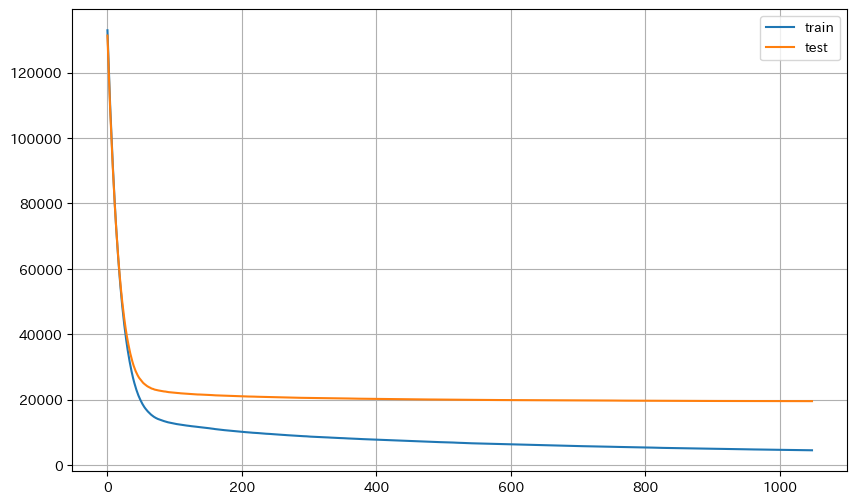

[08:53:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132271.74858	validation_1-rmse:134311.73502
[1]	validation_0-rmse:126317.86827	validation_1-rmse:128509.45162
[2]	validation_0-rmse:120424.58123	validation_1-rmse:122565.77316
[3]	validation_0-rmse:114898.51470	validation_1-rmse:117148.51329


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:109503.75416	validation_1-rmse:111732.44395
[5]	validation_0-rmse:104691.04425	validation_1-rmse:106964.18391
[6]	validation_0-rmse:99964.72294	validation_1-rmse:102305.16349
[7]	validation_0-rmse:95343.69854	validation_1-rmse:97628.80023
[8]	validation_0-rmse:91080.48263	validation_1-rmse:93348.73377
[9]	validation_0-rmse:87017.60108	validation_1-rmse:89404.81201
[10]	validation_0-rmse:83023.83963	validation_1-rmse:85507.63879
[11]	validation_0-rmse:79247.76240	validation_1-rmse:81658.25068
[12]	validation_0-rmse:75661.95483	validation_1-rmse:78112.07615
[13]	validation_0-rmse:72265.19772	validation_1-rmse:74720.59957
[14]	validation_0-rmse:69103.45391	validation_1-rmse:71612.35655
[15]	validation_0-rmse:66038.64900	validation_1-rmse:68694.33496
[16]	validation_0-rmse:63126.91224	validation_1-rmse:65826.26592
[17]	validation_0-rmse:60366.54190	validation_1-rmse:63104.93392
[18]	validation_0-rmse:57764.26666	validation_1-rmse:60597.77509
[19]	validation_0-rmse:552

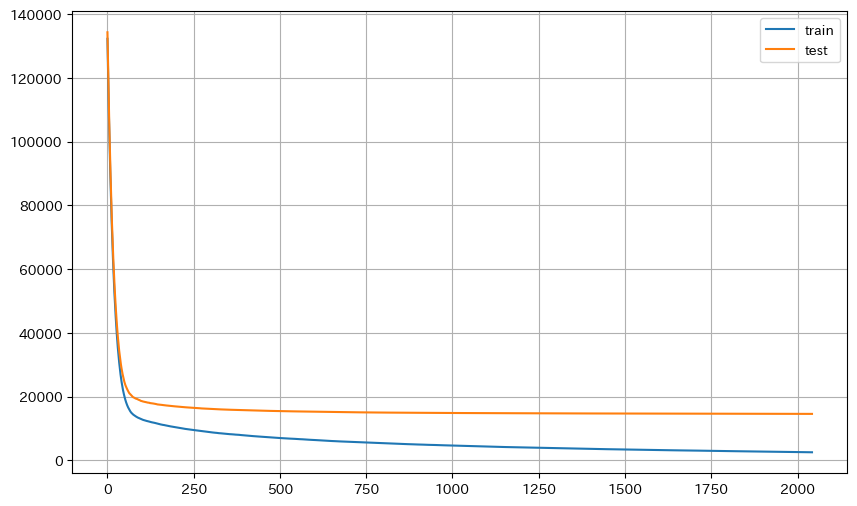

whole valid rmse: 17760.400895623912
Start predicting...


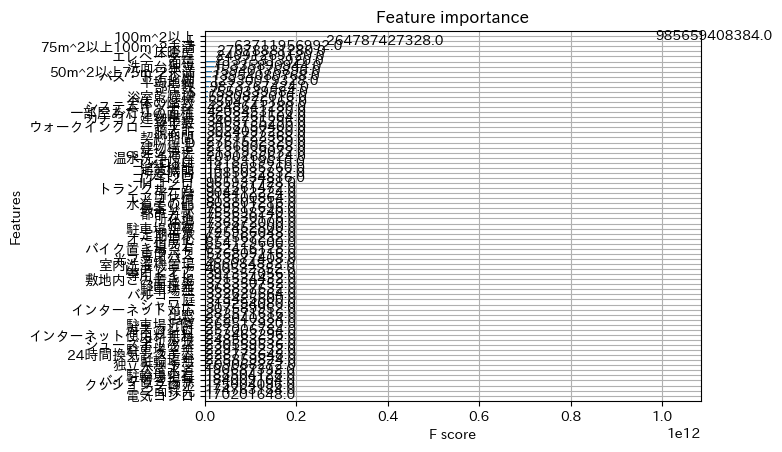

In [4]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    # 学習時に用いる検証用データ
    evals = [(X_tr, 'train'), (X_tr, 'eval')]
    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        # 回帰問題
                        objective='reg:linear',
                        # 学習用の指標 (RMSE)
                        eval_metric='rmse',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        #学習率
                        learning_rate=0.05,
                        #木の最大深さ
                        max_depth=7,
                        #シード値
                        random_state=0,
                            #正則化
                        reg_alfa=6.8594164113286965e-06,

                        sub_sample=0.16056047423047484,

                        colsample_bytree=0.6987351856651322,

                        min_child_weight=1.1103525577197584,
                        
                        evals=evals,

                        evals_result=evals_result
    )
    xgb_reg.fit(X_tr, y_tr, 
                eval_set=[(X_tr, y_tr),(X_val, y_val)], 
                early_stopping_rounds=10, 
            )
    evals_result = xgb_reg.evals_result()
    train_evals = evals_result['validation_0']['rmse']
    test_evals = evals_result['validation_1']['rmse']

    pred_y_val = xgb_reg.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

    # 学習の課程を折れ線グラフとしてプロットする
    print('Plot metrics during training...')
    plt.figure(figsize=(10, 6))
    plt.subplot(111)
    x = range(len(train_evals))
    plt.plot(x, train_evals, label='train')
    plt.plot(x, test_evals, label='test')
    # plt.plot(x, ave_cv_evals, label='validation')
    plt.grid()
    plt.legend()
    plt.show()

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = xgb_reg.predict(X_test)

# feature importanceを表示
xgboost.plot_importance(xgb_reg, importance_type = "gain")
plt.show()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
# sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
# sepa_bath_toilets.columns = ['バス・トイレ別']
# washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
# kitchen_points.drop(['ガスコンロ'],axis=1,inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
# bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
parkings = pd.read_csv('../data/handmade_data/parkings.csv')
# parkings.drop('',axis=1,inplace=True)
building = pd.read_csv('../data/handmade_data/building.csv')
equipments = pd.read_csv('../data/handmade_data/equipments.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
# test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
# test_sepa_bath_toilets.columns = ['バス・トイレ別']
# test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
# test_kitchen_points.drop(['ガスコンロ'],axis=1,inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
# test_bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
test_broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
test_parkings = pd.read_csv('../data/test_data/test_parkings.csv')
# test_parkings.drop('',axis=1,inplace=True)
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')

X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, 
                    stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], 
                    building, buildings,over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
                    kitchen_points,
                    equipments['床暖房']], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, 
                    test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
                    test_building, test_buildings,test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
                    test_kitchen_points,
                    test_equipments['床暖房']], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S','カテゴリ建物構造','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
                    'ガスコンロ', 'コンロ2口', '給湯','システムキッチン', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ',
                    '床暖房'
                    ]

[08:56:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132954.05646	validation_1-rmse:131333.00570
[1]	validation_0-rmse:126869.69798	validation_1-rmse:125398.62170
[2]	validation_0-rmse:120857.32151	validation_1-rmse:119582.82619
[3]	validation_0-rmse:115152.12406	validation_1-rmse:114067.92520
[4]	validation_0-rmse:109895.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-rmse:79043.96335	validation_1-rmse:79358.30187
[12]	validation_0-rmse:75458.46923	validation_1-rmse:75907.13008
[13]	validation_0-rmse:72056.22065	validation_1-rmse:72675.36197
[14]	validation_0-rmse:68903.26741	validation_1-rmse:69726.45374
[15]	validation_0-rmse:65853.93327	validation_1-rmse:66819.54192
[16]	validation_0-rmse:62999.08756	validation_1-rmse:64138.90373
[17]	validation_0-rmse:60274.27935	validation_1-rmse:61598.61181
[18]	validation_0-rmse:57766.91146	validation_1-rmse:59215.49831
[19]	validation_0-rmse:55344.31197	validation_1-rmse:56945.47026
[20]	validation_0-rmse:53113.82835	validation_1-rmse:54869.89349
[21]	validation_0-rmse:50934.26407	validation_1-rmse:52855.08370
[22]	validation_0-rmse:48822.81455	validation_1-rmse:50902.41952
[23]	validation_0-rmse:46853.64593	validation_1-rmse:49006.86929
[24]	validation_0-rmse:45003.25267	validation_1-rmse:47307.49694
[25]	validation_0-rmse:43266.55090	validation_1-rmse:45727.95698
[26]	validation_0-rmse:41

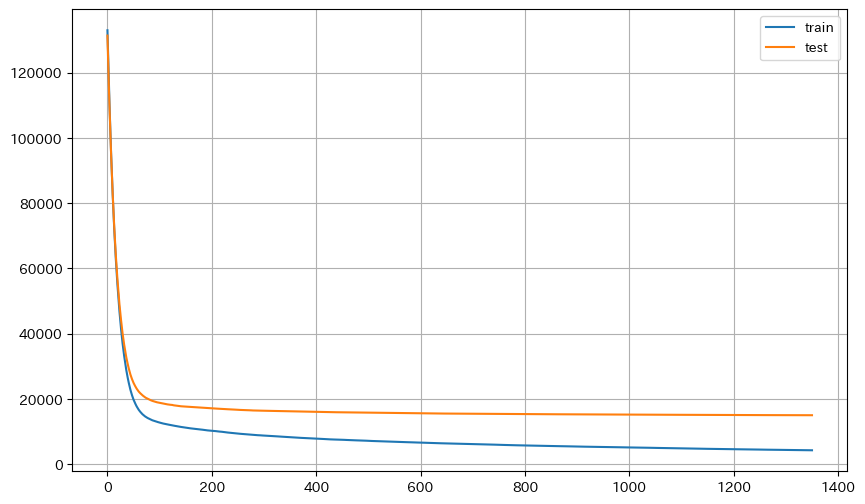

[08:56:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132707.76895	validation_1-rmse:132341.11025
[1]	validation_0-rmse:126645.98949	validation_1-rmse:126441.32496
[2]	validation_0-rmse:120662.10185	validation_1-rmse:120607.70349
[3]	validation_0-rmse:114984.62172	validation_1-rmse:115064.17642
[4]	validation_0-rmse:109739.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:95168.18848	validation_1-rmse:95815.67809
[8]	validation_0-rmse:90768.88076	validation_1-rmse:91490.42812
[9]	validation_0-rmse:86699.48307	validation_1-rmse:87613.17775
[10]	validation_0-rmse:82765.30621	validation_1-rmse:83747.15899
[11]	validation_0-rmse:79004.99094	validation_1-rmse:80173.34262
[12]	validation_0-rmse:75438.70225	validation_1-rmse:76736.93634
[13]	validation_0-rmse:72047.59639	validation_1-rmse:73489.55623
[14]	validation_0-rmse:68904.23566	validation_1-rmse:70448.41839
[15]	validation_0-rmse:65870.09429	validation_1-rmse:67490.54598
[16]	validation_0-rmse:63022.31961	validation_1-rmse:64809.42509
[17]	validation_0-rmse:60302.15948	validation_1-rmse:62276.51862
[18]	validation_0-rmse:57791.55061	validation_1-rmse:59944.37835
[19]	validation_0-rmse:55373.74144	validation_1-rmse:57687.49183
[20]	validation_0-rmse:53178.64724	validation_1-rmse:55660.61959
[21]	validation_0-rmse:51010.40081	validation_1-rmse:53582.63622
[22]	validation_0-rmse:48915

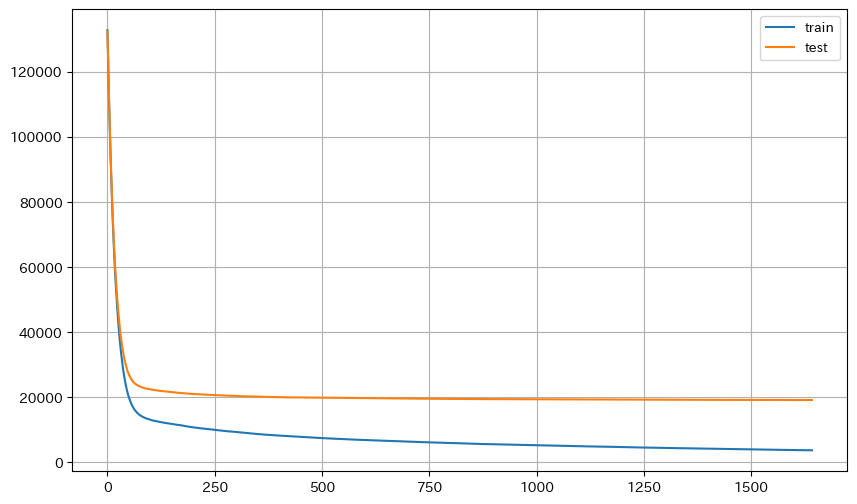

[08:57:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:57:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132272.71201	validation_1-rmse:134091.36003
[1]	validation_0-rmse:126247.43021	validation_1-rmse:127995.98355
[2]	validation_0-rmse:120285.38021	validation_1-rmse:121929.34384
[3]	validation_0-rmse:114638.00684	validation_1-rmse:116169.95416
[4]	validation_0-rmse:109407.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:94904.70356	validation_1-rmse:96366.36780
[8]	validation_0-rmse:90528.92883	validation_1-rmse:91926.02690
[9]	validation_0-rmse:86478.46914	validation_1-rmse:87784.23099
[10]	validation_0-rmse:82557.73904	validation_1-rmse:83846.36479
[11]	validation_0-rmse:78814.40168	validation_1-rmse:80057.49259
[12]	validation_0-rmse:75266.56112	validation_1-rmse:76464.84515
[13]	validation_0-rmse:71901.31831	validation_1-rmse:73061.44417
[14]	validation_0-rmse:68790.73897	validation_1-rmse:69966.93431
[15]	validation_0-rmse:65778.84886	validation_1-rmse:66940.16106
[16]	validation_0-rmse:62945.76745	validation_1-rmse:64078.60539
[17]	validation_0-rmse:60245.68629	validation_1-rmse:61343.65802
[18]	validation_0-rmse:57745.16821	validation_1-rmse:58904.92144
[19]	validation_0-rmse:55327.00959	validation_1-rmse:56469.17252
[20]	validation_0-rmse:53125.20191	validation_1-rmse:54400.21223
[21]	validation_0-rmse:50969.99651	validation_1-rmse:52288.53052
[22]	validation_0-rmse:48873

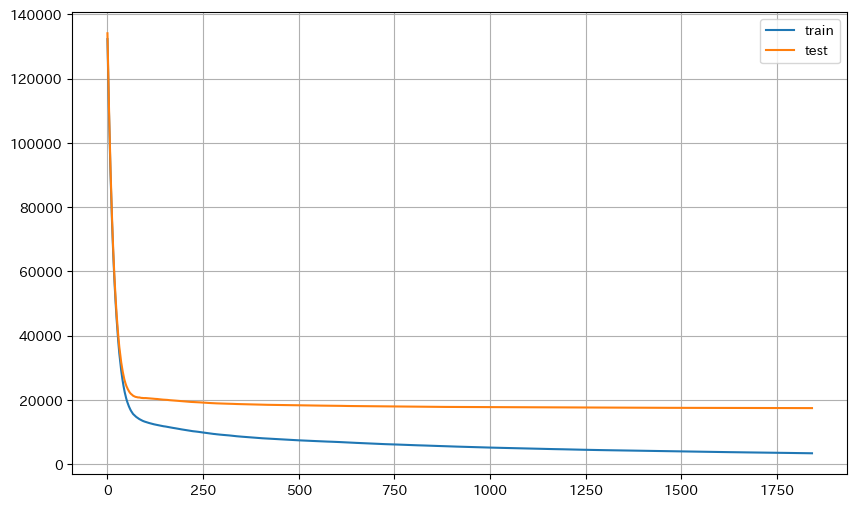

[08:58:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132933.81981	validation_1-rmse:131320.84136
[1]	validation_0-rmse:126859.04106	validation_1-rmse:125333.88140
[2]	validation_0-rmse:120856.05263	validation_1-rmse:119456.16275
[3]	validation_0-rmse:115154.86023	validation_1-rmse:113831.45449
[4]	validation_0-rmse:109902.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:99939.07809	validation_1-rmse:98854.29435
[7]	validation_0-rmse:95288.31327	validation_1-rmse:94325.57028
[8]	validation_0-rmse:90874.33016	validation_1-rmse:90043.53968
[9]	validation_0-rmse:86800.72803	validation_1-rmse:86098.84859
[10]	validation_0-rmse:82845.16774	validation_1-rmse:82279.94279
[11]	validation_0-rmse:79065.97816	validation_1-rmse:78609.38195
[12]	validation_0-rmse:75479.62627	validation_1-rmse:75124.05376
[13]	validation_0-rmse:72078.97310	validation_1-rmse:71813.08595
[14]	validation_0-rmse:68933.14689	validation_1-rmse:68785.92028
[15]	validation_0-rmse:65892.32964	validation_1-rmse:65896.94253
[16]	validation_0-rmse:63027.73505	validation_1-rmse:63138.80721
[17]	validation_0-rmse:60299.24854	validation_1-rmse:60535.36460
[18]	validation_0-rmse:57774.97419	validation_1-rmse:58178.33533
[19]	validation_0-rmse:55349.85779	validation_1-rmse:55907.37749
[20]	validation_0-rmse:53205.31038	validation_1-rmse:53877.13072
[21]	validation_0-rmse:51028.

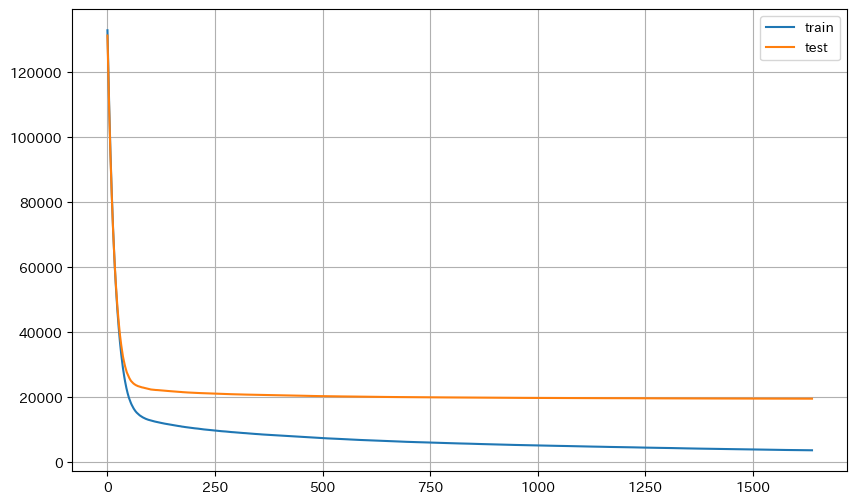

[08:58:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132223.93961	validation_1-rmse:134246.25129
[1]	validation_0-rmse:126180.01206	validation_1-rmse:128216.76102
[2]	validation_0-rmse:120223.58408	validation_1-rmse:122294.49876
[3]	validation_0-rmse:114578.65340	validation_1-rmse:116637.78895
[4]	validation_0-rmse:109352.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:99475.03887	validation_1-rmse:101503.50479
[7]	validation_0-rmse:94866.37425	validation_1-rmse:96914.74598
[8]	validation_0-rmse:90500.59283	validation_1-rmse:92597.33560
[9]	validation_0-rmse:86464.45506	validation_1-rmse:88599.47318
[10]	validation_0-rmse:82547.73346	validation_1-rmse:84555.97536
[11]	validation_0-rmse:78801.65345	validation_1-rmse:80837.14328
[12]	validation_0-rmse:75263.78852	validation_1-rmse:77325.18910
[13]	validation_0-rmse:71903.27233	validation_1-rmse:73942.63131
[14]	validation_0-rmse:68788.21345	validation_1-rmse:70891.16863
[15]	validation_0-rmse:65773.33165	validation_1-rmse:67931.92097
[16]	validation_0-rmse:62945.23226	validation_1-rmse:65091.44174
[17]	validation_0-rmse:60253.98442	validation_1-rmse:62517.55397
[18]	validation_0-rmse:57768.04630	validation_1-rmse:60152.14312
[19]	validation_0-rmse:55370.49161	validation_1-rmse:57824.44914
[20]	validation_0-rmse:53172.03301	validation_1-rmse:55721.41041
[21]	validation_0-rmse:51033

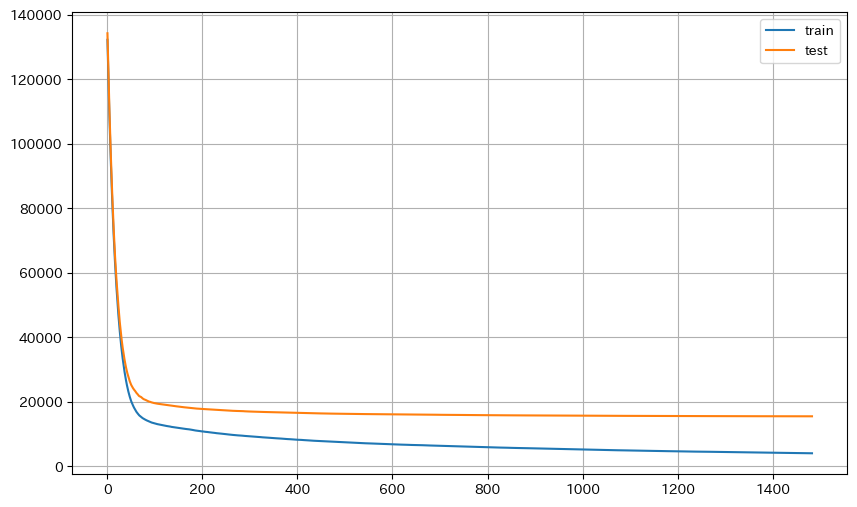

whole valid rmse: 17350.372493147937
Start predicting...


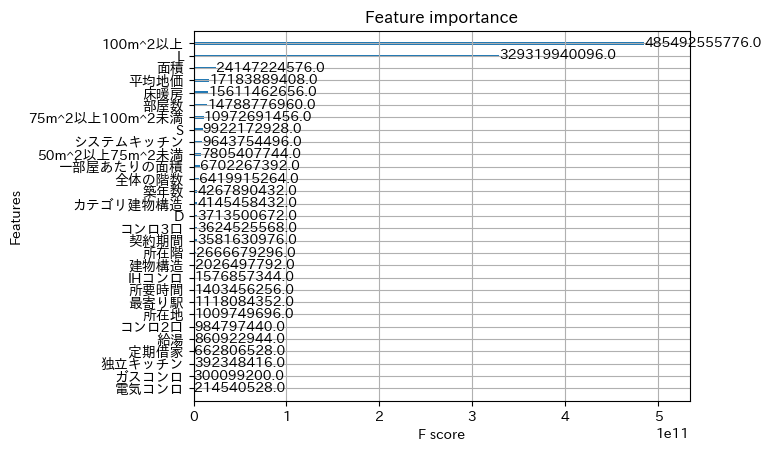

In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    # 学習時に用いる検証用データ
    evals = [(X_tr, 'train'), (X_tr, 'eval')]
    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        # 回帰問題
                        objective='reg:linear',
                        # 学習用の指標 (RMSE)
                        eval_metric='rmse',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        #学習率
                        learning_rate=0.05,
                        #木の最大深さ
                        max_depth=7,
                        #シード値
                        random_state=0,
                            #正則化
                        reg_alfa=6.8594164113286965e-06,

                        sub_sample=0.16056047423047484,

                        colsample_bytree=0.6987351856651322,

                        min_child_weight=1.1103525577197584,
                        
                        evals=evals,

                        evals_result=evals_result
    )
    xgb_reg.fit(X_tr, y_tr, 
                eval_set=[(X_tr, y_tr),(X_val, y_val)], 
                early_stopping_rounds=10, 
            )
    evals_result = xgb_reg.evals_result()
    train_evals = evals_result['validation_0']['rmse']
    test_evals = evals_result['validation_1']['rmse']

    pred_y_val = xgb_reg.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

    # 学習の課程を折れ線グラフとしてプロットする
    print('Plot metrics during training...')
    plt.figure(figsize=(10, 6))
    plt.subplot(111)
    x = range(len(train_evals))
    plt.plot(x, train_evals, label='train')
    plt.plot(x, test_evals, label='test')
    # plt.plot(x, ave_cv_evals, label='validation')
    plt.grid()
    plt.legend()
    plt.show()

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = xgb_reg.predict(X_test)

# feature importanceを表示
xgboost.plot_importance(xgb_reg, importance_type = "gain")
plt.show()

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
# washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
# kitchen_points.drop(['ガスコンロ'],axis=1,inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
# bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
parkings = pd.read_csv('../data/handmade_data/parkings.csv')
# parkings.drop('',axis=1,inplace=True)
building = pd.read_csv('../data/handmade_data/building.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
# test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
# test_kitchen_points.drop(['ガスコンロ'],axis=1,inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
# test_bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
test_broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
test_parkings = pd.read_csv('../data/test_data/test_parkings.csv')
# test_parkings.drop('',axis=1,inplace=True)
test_building = pd.read_csv('../data/test_data/test_building.csv')


# X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, 
#                     stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], 
#                     building,sepa_bath_toilets,over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
#                     ], axis=1)
# y_train = pd.read_csv('../data/handmade_data/rent.csv')
# y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
# X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, 
#                     test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
#                     test_building, test_sepa_bath_toilets,test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
#                     ], axis=1)
# category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
#                     'バス・トイレ別',
#                     'ガスコンロ', 'コンロ2口', '給湯','システムキッチン', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ',
#                     'エアコン付','シューズボックス','バルコニー','室内洗濯機置場','敷地内ごみ置き場','エレベーター','水道その他','都市ガス','タイル張','ウォークインクローゼット','2面採光','3面採光','24時間換気システム','クッションフロア','庭','床暖房','ロフト','出窓','トランクルーム','オール電化',
#                     '専用バス','バス・トイレ別','シャワー','専用トイレ','浴室乾燥機','温水洗浄便座','洗面台独立','脱衣所','追焚機能',
#                     'インターネット対応','catv','csアンテナ','bsアンテナ','光ファイバー','インターネット使用料無料',
#                     '駐車場空有','駐車場空無','駐車場無','駐車場近隣','駐輪場空有','駐輪場無','バイク置き場無','バイク置き場空有'
#                     ]

X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2,kitchen_points], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2,test_kitchen_points], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満'
'ガスコンロ', 'コンロ2口', '給湯','システムキッチン', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ',]

[09:55:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[09:55:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133054.64676	validation_1-rmse:131403.81555
[1]	validation_0-rmse:126747.00167	validation_1-rmse:125293.66139
[2]	validation_0-rmse:120967.45787	validation_1-rmse:119703.64049
[3]	validation_0-rmse:115384.08240	validation_1-rmse:114336.54876
[4]	validation_0-rmse:110060.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-rmse:75849.74083	validation_1-rmse:76451.53997
[13]	validation_0-rmse:72435.30556	validation_1-rmse:73221.46445
[14]	validation_0-rmse:69316.32316	validation_1-rmse:70292.84297
[15]	validation_0-rmse:66395.77897	validation_1-rmse:67536.70142
[16]	validation_0-rmse:63545.43889	validation_1-rmse:64871.19785
[17]	validation_0-rmse:60838.16717	validation_1-rmse:62364.29826
[18]	validation_0-rmse:58241.60798	validation_1-rmse:59955.86389
[19]	validation_0-rmse:55753.19958	validation_1-rmse:57650.40909
[20]	validation_0-rmse:53581.62198	validation_1-rmse:55608.55703
[21]	validation_0-rmse:51392.35733	validation_1-rmse:53587.78165
[22]	validation_0-rmse:49291.51985	validation_1-rmse:51666.00453
[23]	validation_0-rmse:47239.41150	validation_1-rmse:49763.69542
[24]	validation_0-rmse:45322.15430	validation_1-rmse:48008.93657
[25]	validation_0-rmse:43537.94218	validation_1-rmse:46399.83808
[26]	validation_0-rmse:41873.45659	validation_1-rmse:44836.83051
[27]	validation_0-rmse:40

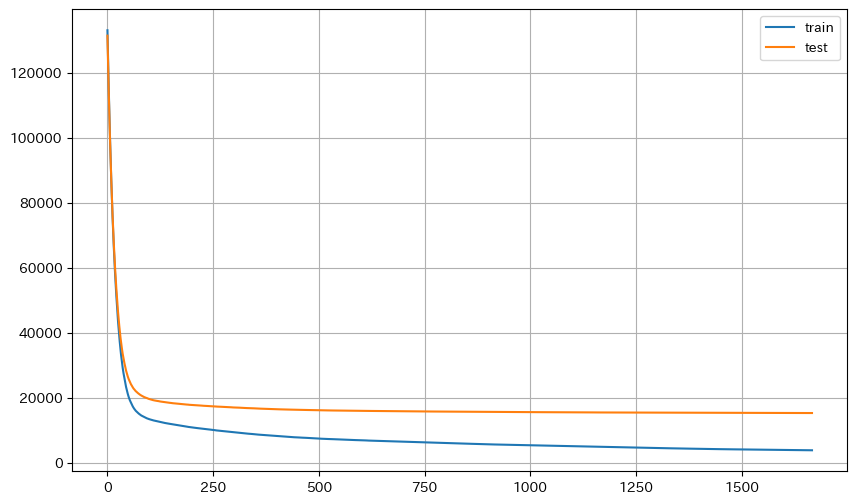

[09:56:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[09:56:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132821.84478	validation_1-rmse:132506.13101
[1]	validation_0-rmse:126531.03747	validation_1-rmse:126327.15854
[2]	validation_0-rmse:120773.91643	validation_1-rmse:120740.98779
[3]	validation_0-rmse:115205.60369	validation_1-rmse:115382.14539
[4]	validation_0-rmse:109899.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:87056.65993	validation_1-rmse:88162.70070
[10]	validation_0-rmse:83067.22691	validation_1-rmse:84263.47425
[11]	validation_0-rmse:79342.67159	validation_1-rmse:80721.72668
[12]	validation_0-rmse:75772.13690	validation_1-rmse:77292.63978
[13]	validation_0-rmse:72368.75594	validation_1-rmse:74010.23860
[14]	validation_0-rmse:69262.37486	validation_1-rmse:71030.98363
[15]	validation_0-rmse:66343.13237	validation_1-rmse:68242.77844
[16]	validation_0-rmse:63495.98208	validation_1-rmse:65479.09513
[17]	validation_0-rmse:60789.62489	validation_1-rmse:62949.34067
[18]	validation_0-rmse:58200.55984	validation_1-rmse:60538.92823
[19]	validation_0-rmse:55711.11858	validation_1-rmse:58181.16688
[20]	validation_0-rmse:53541.36000	validation_1-rmse:56221.91087
[21]	validation_0-rmse:51358.05012	validation_1-rmse:54211.16869
[22]	validation_0-rmse:49274.02368	validation_1-rmse:52304.55013
[23]	validation_0-rmse:47230.96389	validation_1-rmse:50360.77593
[24]	validation_0-rmse:453

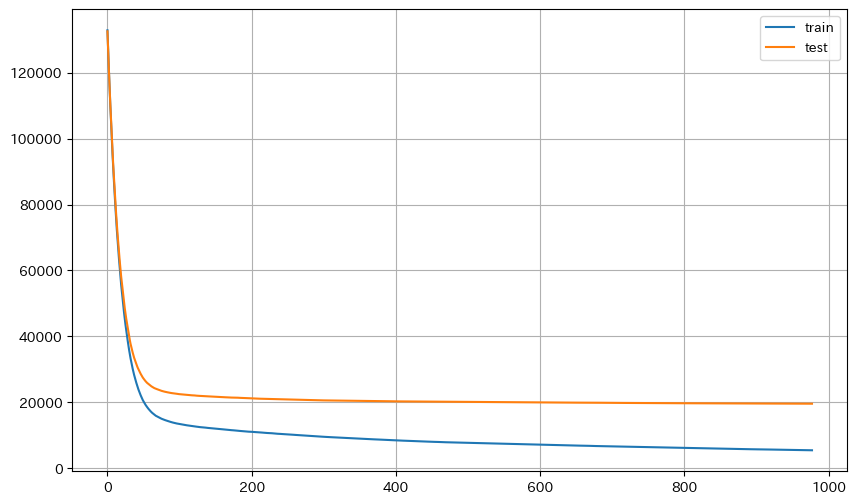

[09:56:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[09:56:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132366.71418	validation_1-rmse:134058.10979
[1]	validation_0-rmse:126115.34350	validation_1-rmse:127703.60718
[2]	validation_0-rmse:120379.53353	validation_1-rmse:121800.52480
[3]	validation_0-rmse:114846.15487	validation_1-rmse:116201.28721
[4]	validation_0-rmse:109573.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:86843.19136	validation_1-rmse:87836.13489
[10]	validation_0-rmse:82873.22350	validation_1-rmse:83790.12454
[11]	validation_0-rmse:79170.64496	validation_1-rmse:80047.30551
[12]	validation_0-rmse:75628.27932	validation_1-rmse:76465.36904
[13]	validation_0-rmse:72237.18792	validation_1-rmse:73043.53587
[14]	validation_0-rmse:69151.54609	validation_1-rmse:69914.08965
[15]	validation_0-rmse:66241.27609	validation_1-rmse:66989.43228
[16]	validation_0-rmse:63400.39703	validation_1-rmse:64163.61446
[17]	validation_0-rmse:60705.42237	validation_1-rmse:61434.37400
[18]	validation_0-rmse:58142.25035	validation_1-rmse:58875.64081
[19]	validation_0-rmse:55674.90259	validation_1-rmse:56392.31990
[20]	validation_0-rmse:53516.42288	validation_1-rmse:54276.95542
[21]	validation_0-rmse:51341.12717	validation_1-rmse:52063.40665
[22]	validation_0-rmse:49263.93705	validation_1-rmse:50014.74547
[23]	validation_0-rmse:47236.67575	validation_1-rmse:48041.71975
[24]	validation_0-rmse:453

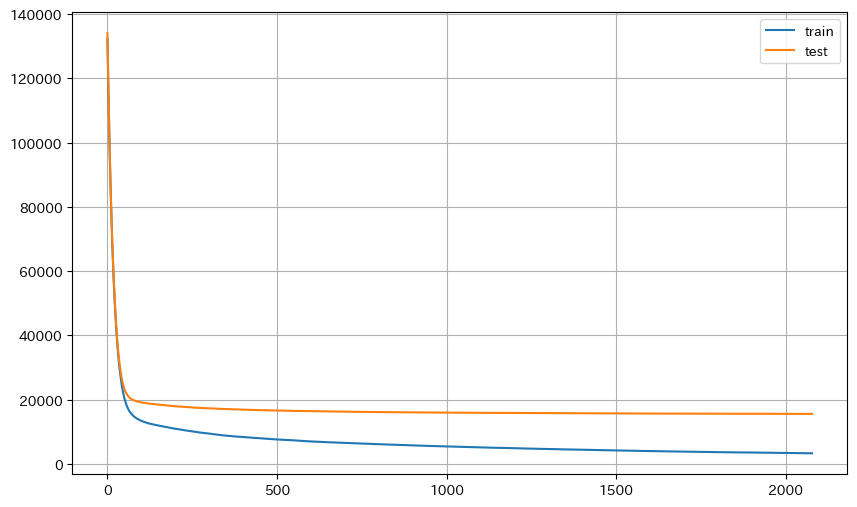

[09:56:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[09:56:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133054.16203	validation_1-rmse:131413.67720
[1]	validation_0-rmse:126746.32523	validation_1-rmse:125209.86313
[2]	validation_0-rmse:120978.64557	validation_1-rmse:119553.13245
[3]	validation_0-rmse:115411.90556	validation_1-rmse:114077.04660
[4]	validation_0-rmse:110105.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:91173.51983	validation_1-rmse:90306.32272
[9]	validation_0-rmse:87200.49493	validation_1-rmse:86452.41649
[10]	validation_0-rmse:83196.95151	validation_1-rmse:82596.13989
[11]	validation_0-rmse:79475.34193	validation_1-rmse:79011.44392
[12]	validation_0-rmse:75895.87006	validation_1-rmse:75546.07062
[13]	validation_0-rmse:72472.60290	validation_1-rmse:72260.36871
[14]	validation_0-rmse:69360.07571	validation_1-rmse:69298.06033
[15]	validation_0-rmse:66435.24024	validation_1-rmse:66509.09149
[16]	validation_0-rmse:63571.64541	validation_1-rmse:63733.89003
[17]	validation_0-rmse:60865.13173	validation_1-rmse:61128.11166
[18]	validation_0-rmse:58281.66765	validation_1-rmse:58674.44302
[19]	validation_0-rmse:55786.54154	validation_1-rmse:56334.40636
[20]	validation_0-rmse:53619.98745	validation_1-rmse:54315.71510
[21]	validation_0-rmse:51437.69641	validation_1-rmse:52227.82725
[22]	validation_0-rmse:49334.00550	validation_1-rmse:50242.78413
[23]	validation_0-rmse:4728

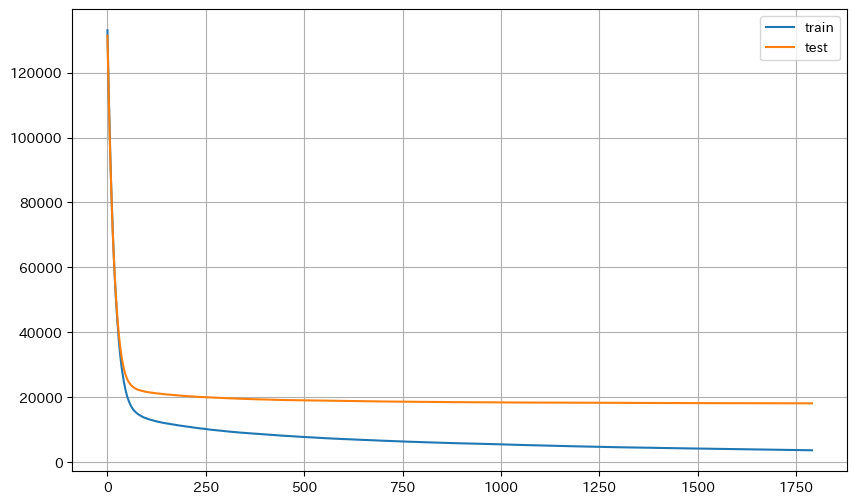

[09:57:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132314.95652	validation_1-rmse:134464.11481
[1]	validation_0-rmse:126057.99551	validation_1-rmse:128172.44757
[2]	validation_0-rmse:120334.47907	validation_1-rmse:122518.91066
[3]	validation_0-rmse:114820.79470	validation_1-rmse:117128.44502
[4]	validation_0-rmse:109541.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:95152.35629	validation_1-rmse:97505.01305
[8]	validation_0-rmse:90769.34550	validation_1-rmse:93105.17311
[9]	validation_0-rmse:86831.71796	validation_1-rmse:89220.05559
[10]	validation_0-rmse:82856.41496	validation_1-rmse:85166.71644
[11]	validation_0-rmse:79150.96690	validation_1-rmse:81534.79196
[12]	validation_0-rmse:75598.56837	validation_1-rmse:77992.20756
[13]	validation_0-rmse:72203.91193	validation_1-rmse:74539.77557
[14]	validation_0-rmse:69130.03531	validation_1-rmse:71382.17403
[15]	validation_0-rmse:66230.87505	validation_1-rmse:68573.85696
[16]	validation_0-rmse:63400.94400	validation_1-rmse:65720.97379
[17]	validation_0-rmse:60724.57994	validation_1-rmse:63147.44733
[18]	validation_0-rmse:58164.27243	validation_1-rmse:60682.09653
[19]	validation_0-rmse:55696.35957	validation_1-rmse:58258.84383
[20]	validation_0-rmse:53558.04359	validation_1-rmse:56166.65606
[21]	validation_0-rmse:51396.56039	validation_1-rmse:54159.19901
[22]	validation_0-rmse:49321

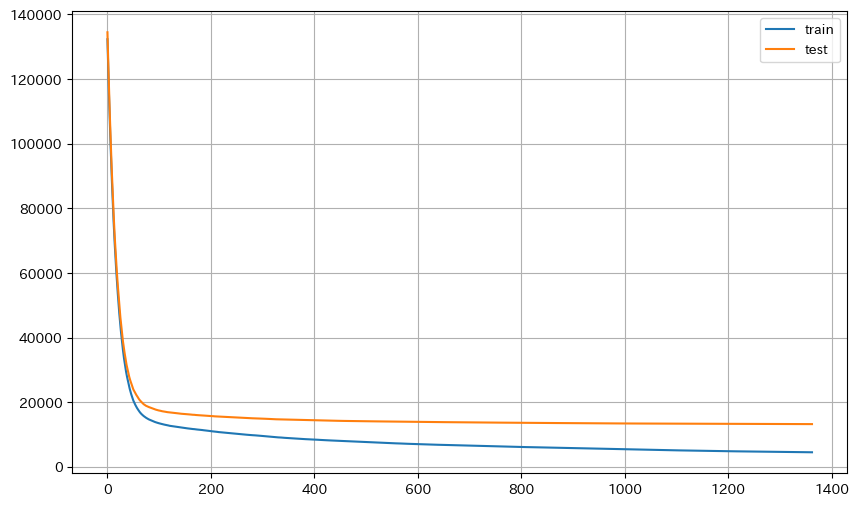

whole valid rmse: 16365.91008549963
Start predicting...


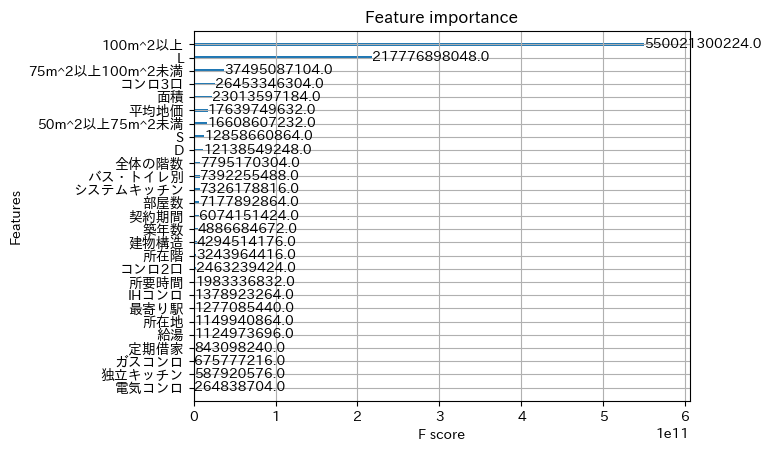

In [34]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    # 学習時に用いる検証用データ
    evals = [(X_tr, 'train'), (X_tr, 'eval')]
    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        # 回帰問題
                        objective='reg:linear',
                        # 学習用の指標 (RMSE)
                        eval_metric='rmse',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        #学習率
                        learning_rate=0.05,
                        #木の最大深さ
                        max_depth=7,
                        #シード値
                        random_state=0,
                            #正則化
                        reg_alfa=6.8594164113286965e-06,

                        sub_sample=0.16056047423047484,

                        colsample_bytree=0.6987351856651322,

                        min_child_weight=1.1103525577197584,
                        
                        evals=evals,

                        evals_result=evals_result
    )
    xgb_reg.fit(X_tr, y_tr, 
                eval_set=[(X_tr, y_tr),(X_val, y_val)], 
                early_stopping_rounds=10, 
            )
    evals_result = xgb_reg.evals_result()
    train_evals = evals_result['validation_0']['rmse']
    test_evals = evals_result['validation_1']['rmse']

    pred_y_val = xgb_reg.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

    # 学習の課程を折れ線グラフとしてプロットする
    print('Plot metrics during training...')
    plt.figure(figsize=(10, 6))
    plt.subplot(111)
    x = range(len(train_evals))
    plt.plot(x, train_evals, label='train')
    plt.plot(x, test_evals, label='test')
    # plt.plot(x, ave_cv_evals, label='validation')
    plt.grid()
    plt.legend()
    plt.show()

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = xgb_reg.predict(X_test)

# feature importanceを表示
xgboost.plot_importance(xgb_reg, importance_type = "gain")
plt.show()

In [35]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/XGB_cv_result.csv',index=False)

# 「キッチン」を入れたら現状の最良のスコア16365!!

引き続き他の特徴量を入れていく

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
# washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
# kitchen_points.drop(['IHコンロ'],axis=1,inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
# bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
parkings = pd.read_csv('../data/handmade_data/parkings.csv')
# parkings.drop('',axis=1,inplace=True)
building = pd.read_csv('../data/handmade_data/building.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
# test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
# test_kitchen_points.drop(['IHコンロ'],axis=1,inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
# test_bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
test_broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
test_parkings = pd.read_csv('../data/test_data/test_parkings.csv')
# test_parkings.drop('',axis=1,inplace=True)
test_building = pd.read_csv('../data/test_data/test_building.csv')


# X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, 
#                     stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], 
#                     building,sepa_bath_toilets,over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
#                     ], axis=1)
# y_train = pd.read_csv('../data/handmade_data/rent.csv')
# y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
# X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, 
#                     test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
#                     test_building, test_sepa_bath_toilets,test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
#                     ], axis=1)
# category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
#                     'バス・トイレ別',
#                     'ガスコンロ', 'コンロ2口', '給湯','システムキッチン', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ',
#                     'エアコン付','シューズボックス','バルコニー','室内洗濯機置場','敷地内ごみ置き場','エレベーター','水道その他','都市ガス','タイル張','ウォークインクローゼット','2面採光','3面採光','24時間換気システム','クッションフロア','庭','床暖房','ロフト','出窓','トランクルーム','オール電化',
#                     '専用バス','バス・トイレ別','シャワー','専用トイレ','浴室乾燥機','温水洗浄便座','洗面台独立','脱衣所','追焚機能',
#                     'インターネット対応','catv','csアンテナ','bsアンテナ','光ファイバー','インターネット使用料無料',
#                     '駐車場空有','駐車場空無','駐車場無','駐車場近隣','駐輪場空有','駐輪場無','バイク置き場無','バイク置き場空有'
#                     ]

X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], buildings, over100m2, bt75and100m2, bt50and75m2,
sepa_bath_toilets, 
kitchen_points], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']], test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2,
test_sepa_bath_toilets,
test_kitchen_points], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', '建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満'
'バス・トイレ別',
'ガスコンロ', 'コンロ2口', '給湯','システムキッチン', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ'
# 'エアコン付','シューズボックス','バルコニー','室内洗濯機置場','敷地内ごみ置き場','エレベーター','水道その他','都市ガス','タイル張','ウォークインクローゼット','2面採光','3面採光','24時間換気システム','クッションフロア','庭','床暖房','ロフト','出窓','トランクルーム','オール電化',
# '専用バス','バス・トイレ別','シャワー','専用トイレ','浴室乾燥機','温水洗浄便座','洗面台独立','脱衣所','追焚機能',
# 'インターネット対応','catv','csアンテナ','bsアンテナ','光ファイバー','インターネット使用料無料',
# '駐車場空有','駐車場空無','駐車場無','駐車場近隣','駐輪場空有','駐輪場無','バイク置き場無','バイク置き場空有'
]

[11:09:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133028.54384	validation_1-rmse:131368.11435
[1]	validation_0-rmse:126722.32397	validation_1-rmse:125260.14718
[2]	validation_0-rmse:120925.03629	validation_1-rmse:119679.08247
[3]	validation_0-rmse:115349.54896	validation_1-rmse:114305.26515
[4]	validation_0-rmse:110100.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-rmse:75923.88225	validation_1-rmse:76536.98067
[13]	validation_0-rmse:72501.32412	validation_1-rmse:73286.61378
[14]	validation_0-rmse:69380.29760	validation_1-rmse:70383.11459
[15]	validation_0-rmse:66396.41361	validation_1-rmse:67544.12601
[16]	validation_0-rmse:63541.20981	validation_1-rmse:64878.04247
[17]	validation_0-rmse:60822.04144	validation_1-rmse:62348.49471
[18]	validation_0-rmse:58222.94049	validation_1-rmse:59953.82082
[19]	validation_0-rmse:55740.82538	validation_1-rmse:57626.58966
[20]	validation_0-rmse:53497.31883	validation_1-rmse:55543.10357
[21]	validation_0-rmse:51308.00810	validation_1-rmse:53528.15804
[22]	validation_0-rmse:49214.65850	validation_1-rmse:51622.26566
[23]	validation_0-rmse:47171.14311	validation_1-rmse:49763.31722
[24]	validation_0-rmse:45258.86273	validation_1-rmse:48012.65158
[25]	validation_0-rmse:43483.89878	validation_1-rmse:46408.03452
[26]	validation_0-rmse:41818.38368	validation_1-rmse:44871.12185
[27]	validation_0-rmse:40

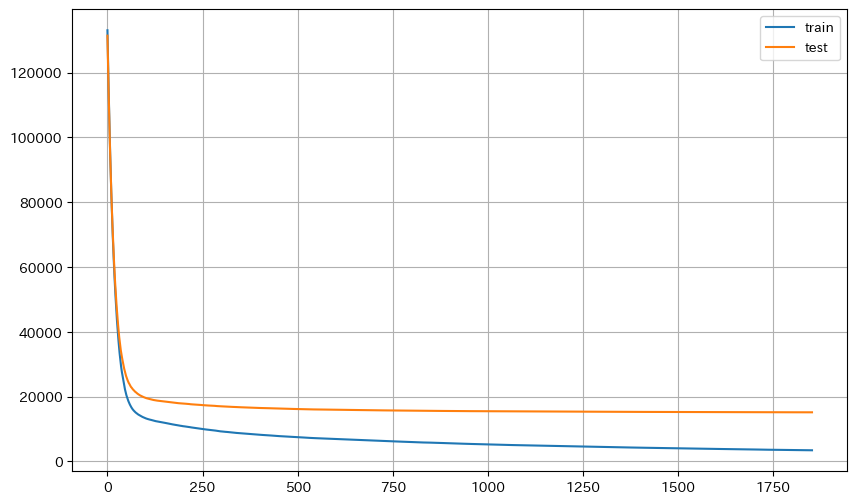

[11:10:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132798.27902	validation_1-rmse:132492.10626
[1]	validation_0-rmse:126510.08053	validation_1-rmse:126324.29824
[2]	validation_0-rmse:120733.58772	validation_1-rmse:120743.83546
[3]	validation_0-rmse:115167.60309	validation_1-rmse:115368.78754
[4]	validation_0-rmse:109940.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:87176.46614	validation_1-rmse:88138.05329
[10]	validation_0-rmse:83188.37807	validation_1-rmse:84182.63352
[11]	validation_0-rmse:79462.75796	validation_1-rmse:80669.38497
[12]	validation_0-rmse:75892.86400	validation_1-rmse:77235.70256
[13]	validation_0-rmse:72479.96390	validation_1-rmse:73946.20981
[14]	validation_0-rmse:69376.59537	validation_1-rmse:70971.10223
[15]	validation_0-rmse:66396.66864	validation_1-rmse:68159.21955
[16]	validation_0-rmse:63539.53325	validation_1-rmse:65413.42458
[17]	validation_0-rmse:60854.50333	validation_1-rmse:62842.04061
[18]	validation_0-rmse:58265.87993	validation_1-rmse:60471.34813
[19]	validation_0-rmse:55779.98067	validation_1-rmse:58065.70625
[20]	validation_0-rmse:53547.32483	validation_1-rmse:55994.46520
[21]	validation_0-rmse:51370.10098	validation_1-rmse:53955.66413
[22]	validation_0-rmse:49286.11151	validation_1-rmse:52047.13976
[23]	validation_0-rmse:47243.59010	validation_1-rmse:50173.22523
[24]	validation_0-rmse:453

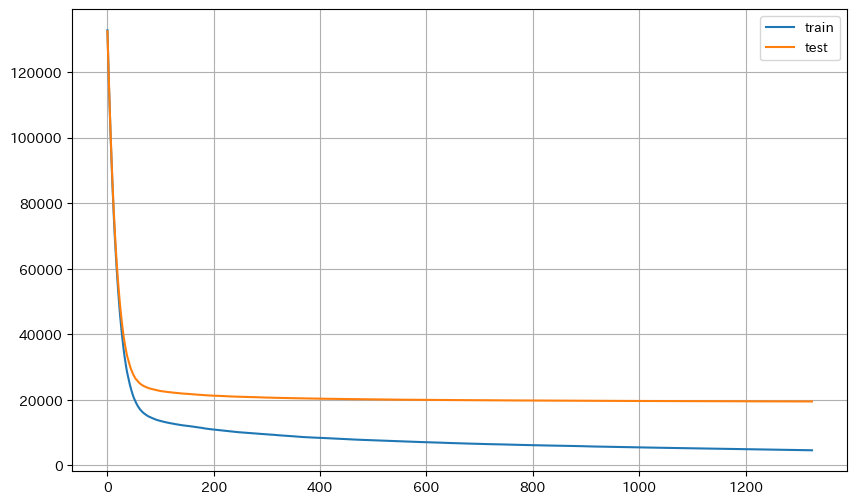

[11:10:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132338.24957	validation_1-rmse:134044.34665
[1]	validation_0-rmse:126089.07196	validation_1-rmse:127689.17057
[2]	validation_0-rmse:120337.65557	validation_1-rmse:121710.21536
[3]	validation_0-rmse:114804.33822	validation_1-rmse:116102.66224
[4]	validation_0-rmse:109625.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:90985.22089	validation_1-rmse:91843.77470
[9]	validation_0-rmse:86950.34841	validation_1-rmse:87780.49558
[10]	validation_0-rmse:82979.86723	validation_1-rmse:83714.58855
[11]	validation_0-rmse:79274.94429	validation_1-rmse:79961.62079
[12]	validation_0-rmse:75732.35069	validation_1-rmse:76430.13688
[13]	validation_0-rmse:72338.56551	validation_1-rmse:72965.61898
[14]	validation_0-rmse:69253.16312	validation_1-rmse:69815.23310
[15]	validation_0-rmse:66284.42840	validation_1-rmse:66844.84799
[16]	validation_0-rmse:63439.47939	validation_1-rmse:64002.99685
[17]	validation_0-rmse:60757.41309	validation_1-rmse:61282.76008
[18]	validation_0-rmse:58186.52509	validation_1-rmse:58691.59167
[19]	validation_0-rmse:55717.12320	validation_1-rmse:56255.85939
[20]	validation_0-rmse:53500.92202	validation_1-rmse:53982.95774
[21]	validation_0-rmse:51330.54983	validation_1-rmse:51836.01185
[22]	validation_0-rmse:49258.15885	validation_1-rmse:49777.42236
[23]	validation_0-rmse:4723

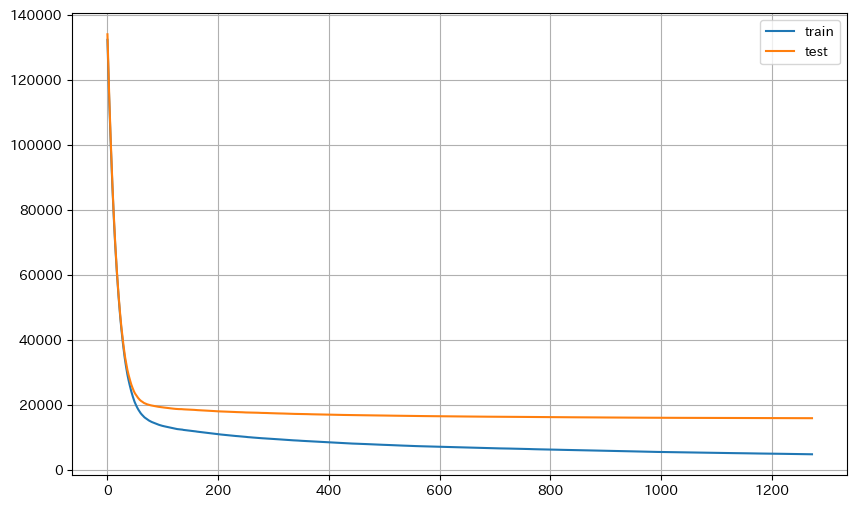

[11:10:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133028.42877	validation_1-rmse:131413.10835
[1]	validation_0-rmse:126723.28195	validation_1-rmse:125210.09476
[2]	validation_0-rmse:120935.23857	validation_1-rmse:119543.49016
[3]	validation_0-rmse:115368.51274	validation_1-rmse:114072.90583
[4]	validation_0-rmse:110146.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:87295.31321	validation_1-rmse:86433.47173
[10]	validation_0-rmse:83290.50773	validation_1-rmse:82551.48060
[11]	validation_0-rmse:79568.33255	validation_1-rmse:78975.35285
[12]	validation_0-rmse:75985.82083	validation_1-rmse:75510.27534
[13]	validation_0-rmse:72563.88531	validation_1-rmse:72227.20651
[14]	validation_0-rmse:69449.42586	validation_1-rmse:69263.45190
[15]	validation_0-rmse:66481.28768	validation_1-rmse:66470.34803
[16]	validation_0-rmse:63613.70568	validation_1-rmse:63698.92599
[17]	validation_0-rmse:60903.55874	validation_1-rmse:61111.28126
[18]	validation_0-rmse:58315.58171	validation_1-rmse:58645.48501
[19]	validation_0-rmse:55820.73287	validation_1-rmse:56289.39837
[20]	validation_0-rmse:53571.64232	validation_1-rmse:54156.56795
[21]	validation_0-rmse:51382.91825	validation_1-rmse:52079.44715
[22]	validation_0-rmse:49297.11279	validation_1-rmse:50121.13979
[23]	validation_0-rmse:47251.14540	validation_1-rmse:48212.39461
[24]	validation_0-rmse:453

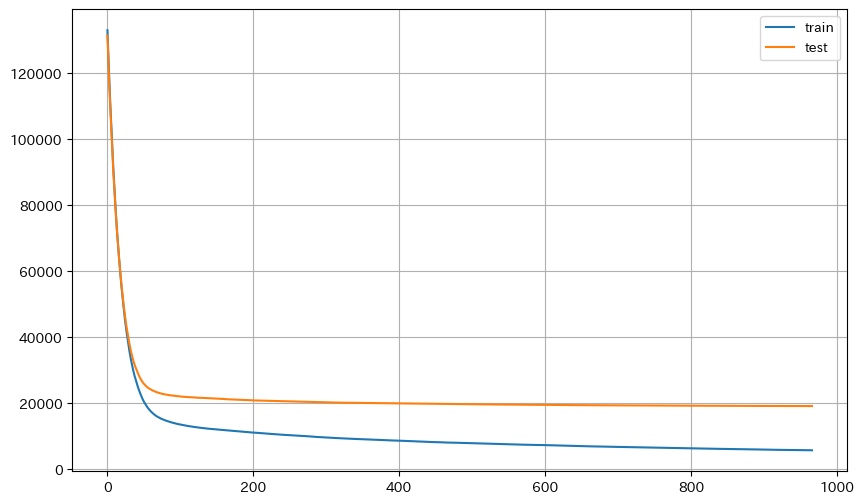

[11:11:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132293.35388	validation_1-rmse:134443.26160
[1]	validation_0-rmse:126037.49755	validation_1-rmse:128154.61149
[2]	validation_0-rmse:120295.50238	validation_1-rmse:122497.11104
[3]	validation_0-rmse:114782.45535	validation_1-rmse:117119.39364
[4]	validation_0-rmse:109604.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:90965.11323	validation_1-rmse:93238.55938
[9]	validation_0-rmse:86934.27431	validation_1-rmse:89158.67461
[10]	validation_0-rmse:82964.85311	validation_1-rmse:85132.24659
[11]	validation_0-rmse:79261.67689	validation_1-rmse:81486.84248
[12]	validation_0-rmse:75709.32085	validation_1-rmse:77985.92259
[13]	validation_0-rmse:72331.23355	validation_1-rmse:74565.08552
[14]	validation_0-rmse:69254.99569	validation_1-rmse:71396.11784
[15]	validation_0-rmse:66319.55938	validation_1-rmse:68492.69357
[16]	validation_0-rmse:63485.76922	validation_1-rmse:65653.70579
[17]	validation_0-rmse:60815.75441	validation_1-rmse:63071.75056
[18]	validation_0-rmse:58255.86625	validation_1-rmse:60583.34881
[19]	validation_0-rmse:55784.07651	validation_1-rmse:58192.75571
[20]	validation_0-rmse:53556.42906	validation_1-rmse:55986.32476
[21]	validation_0-rmse:51396.21395	validation_1-rmse:53975.38057
[22]	validation_0-rmse:49329.42257	validation_1-rmse:51830.98052
[23]	validation_0-rmse:4730

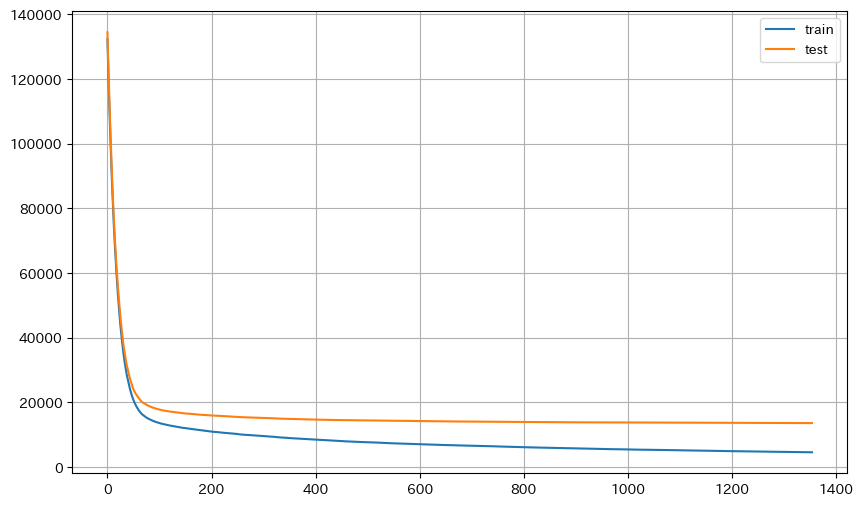

whole valid rmse: 16641.3015888945
Start predicting...


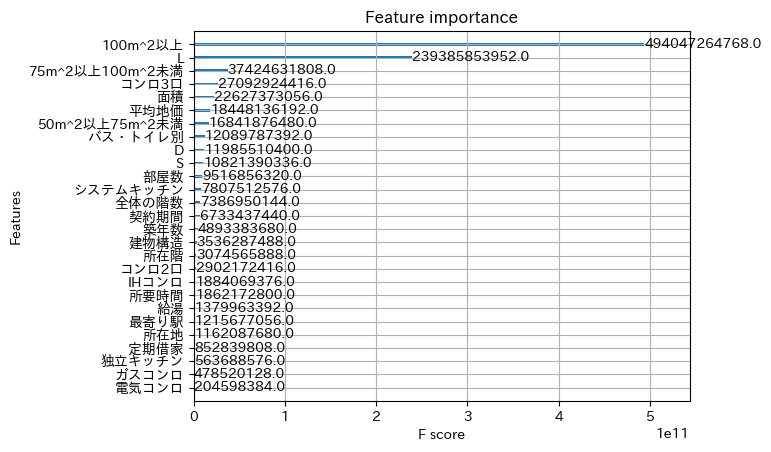

In [75]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    # 学習時に用いる検証用データ
    evals = [(X_tr, 'train'), (X_tr, 'eval')]
    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        # 回帰問題
                        objective='reg:linear',
                        # 学習用の指標 (RMSE)
                        eval_metric='rmse',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        #学習率
                        learning_rate=0.05,
                        #木の最大深さ
                        max_depth=7,
                        #シード値
                        random_state=0,
                            #正則化
                        reg_alfa=6.8594164113286965e-06,

                        sub_sample=0.16056047423047484,

                        colsample_bytree=0.6987351856651322,

                        min_child_weight=1.1103525577197584,
                        
                        evals=evals,

                        evals_result=evals_result
    )
    xgb_reg.fit(X_tr, y_tr, 
                eval_set=[(X_tr, y_tr),(X_val, y_val)], 
                early_stopping_rounds=10, 
            )
    evals_result = xgb_reg.evals_result()
    train_evals = evals_result['validation_0']['rmse']
    test_evals = evals_result['validation_1']['rmse']

    pred_y_val = xgb_reg.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

    # 学習の課程を折れ線グラフとしてプロットする
    print('Plot metrics during training...')
    plt.figure(figsize=(10, 6))
    plt.subplot(111)
    x = range(len(train_evals))
    plt.plot(x, train_evals, label='train')
    plt.plot(x, test_evals, label='test')
    # plt.plot(x, ave_cv_evals, label='validation')
    plt.grid()
    plt.legend()
    plt.show()

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = xgb_reg.predict(X_test)

# feature importanceを表示
xgboost.plot_importance(xgb_reg, importance_type = "gain")
plt.show()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
building = pd.read_csv('../data/handmade_data/building.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over110m2 = pd.read_csv('../data/handmade_data/over110m2.csv')
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
over90m2 = pd.read_csv('../data/handmade_data/over90m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
latitude_longitude = pd.read_csv('../data/handmade_data/latitude_longitude.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over110m2 = pd.read_csv('../data/test_data/test_over110m2.csv')
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_over90m2 = pd.read_csv('../data/test_data/test_over90m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_latitude_longitude = pd.read_csv('../data/test_data/test_latitude_longitude.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2,bt75and100m2, bt50and75m2, area_per_rooms, kitchen_points[['コンロ2口']], latitude_longitude[['平均緯度', '平均経度']]], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms, test_kitchen_points[['コンロ2口']], test_latitude_longitude[['平均緯度','平均経度']]], axis=1)
category_lists = ['定期借家','最寄り駅', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 'コンロ2口']

[14:14:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132955.52144	validation_1-rmse:131288.72870
[1]	validation_0-rmse:126640.04952	validation_1-rmse:125191.62823
[2]	validation_0-rmse:120645.78397	validation_1-rmse:119399.16261
[3]	validation_0-rmse:115003.48081	validation_1-rmse:113934.57699
[4]	validation_0-rmse:109640.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-rmse:78987.42945	validation_1-rmse:79386.96306
[12]	validation_0-rmse:75412.75355	validation_1-rmse:75956.73919
[13]	validation_0-rmse:72058.57663	validation_1-rmse:72743.07615
[14]	validation_0-rmse:68840.21630	validation_1-rmse:69702.63687
[15]	validation_0-rmse:65825.13015	validation_1-rmse:66885.88589
[16]	validation_0-rmse:62909.63214	validation_1-rmse:64135.38847
[17]	validation_0-rmse:60137.44922	validation_1-rmse:61507.15928
[18]	validation_0-rmse:57643.59396	validation_1-rmse:59086.36808
[19]	validation_0-rmse:55169.79816	validation_1-rmse:56861.54466
[20]	validation_0-rmse:52836.66788	validation_1-rmse:54703.72486
[21]	validation_0-rmse:50613.77522	validation_1-rmse:52616.35055
[22]	validation_0-rmse:48484.06680	validation_1-rmse:50657.25730
[23]	validation_0-rmse:46496.38301	validation_1-rmse:48834.30510
[24]	validation_0-rmse:44621.51168	validation_1-rmse:47101.27541
[25]	validation_0-rmse:42840.00229	validation_1-rmse:45488.73257
[26]	validation_0-rmse:41

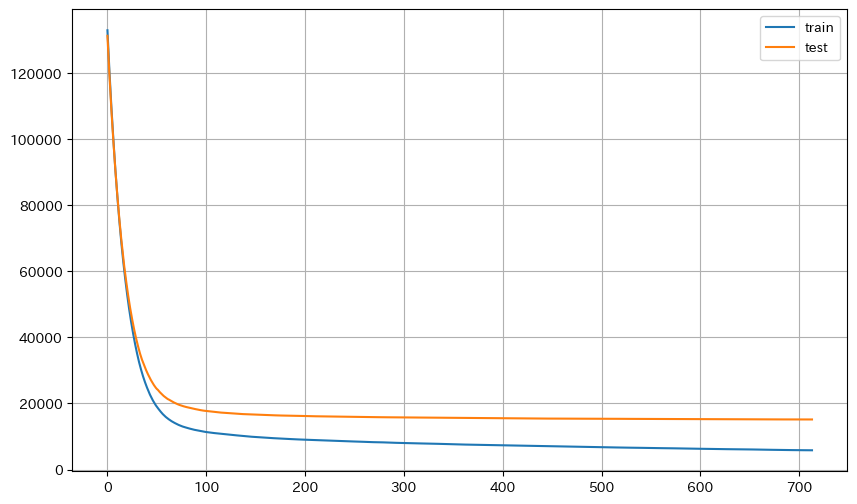

[14:14:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132701.97642	validation_1-rmse:132291.18554
[1]	validation_0-rmse:126411.57490	validation_1-rmse:126123.04108
[2]	validation_0-rmse:120438.54952	validation_1-rmse:120201.91952
[3]	validation_0-rmse:114824.17762	validation_1-rmse:114730.78780
[4]	validation_0-rmse:109474.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:90689.27107	validation_1-rmse:91240.61630
[9]	validation_0-rmse:86599.06588	validation_1-rmse:87206.14990
[10]	validation_0-rmse:82685.99826	validation_1-rmse:83448.62364
[11]	validation_0-rmse:78913.12951	validation_1-rmse:79811.59531
[12]	validation_0-rmse:75348.36093	validation_1-rmse:76291.00719
[13]	validation_0-rmse:72003.42674	validation_1-rmse:73161.22669
[14]	validation_0-rmse:68803.15661	validation_1-rmse:70099.93392
[15]	validation_0-rmse:65804.00745	validation_1-rmse:67258.52337
[16]	validation_0-rmse:62891.16965	validation_1-rmse:64487.42509
[17]	validation_0-rmse:60139.56169	validation_1-rmse:61847.44970
[18]	validation_0-rmse:57646.81661	validation_1-rmse:59544.77672
[19]	validation_0-rmse:55183.85655	validation_1-rmse:57218.62647
[20]	validation_0-rmse:52856.93797	validation_1-rmse:55033.90798
[21]	validation_0-rmse:50645.84048	validation_1-rmse:52941.92893
[22]	validation_0-rmse:48528.93837	validation_1-rmse:50961.77232
[23]	validation_0-rmse:4655

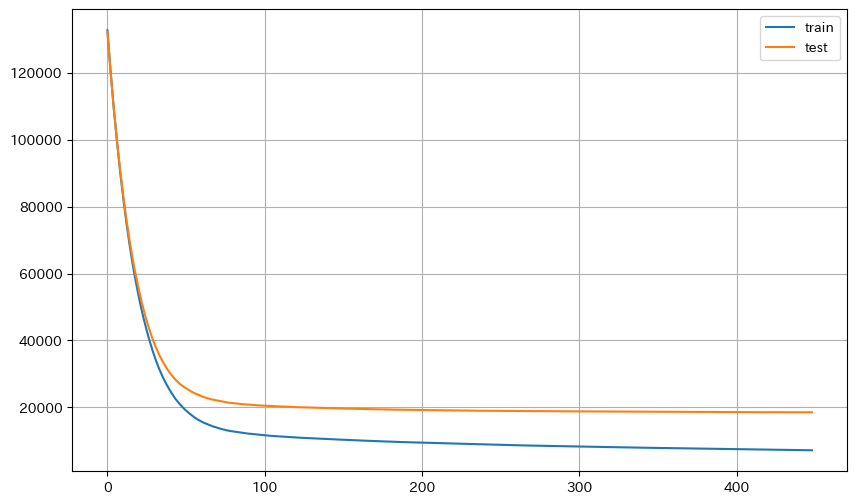

[14:14:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132255.53173	validation_1-rmse:133990.72581
[1]	validation_0-rmse:126003.81142	validation_1-rmse:127662.33650
[2]	validation_0-rmse:120053.80261	validation_1-rmse:121616.30796
[3]	validation_0-rmse:114455.08385	validation_1-rmse:115915.25297
[4]	validation_0-rmse:109129.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:90437.26821	validation_1-rmse:91561.55652
[9]	validation_0-rmse:86371.74230	validation_1-rmse:87427.50353
[10]	validation_0-rmse:82483.01248	validation_1-rmse:83434.00140
[11]	validation_0-rmse:78731.94314	validation_1-rmse:79688.57804
[12]	validation_0-rmse:75183.21788	validation_1-rmse:76122.32971
[13]	validation_0-rmse:71859.98345	validation_1-rmse:72710.07295
[14]	validation_0-rmse:68663.92821	validation_1-rmse:69474.44615
[15]	validation_0-rmse:65685.24326	validation_1-rmse:66527.62325
[16]	validation_0-rmse:62787.61384	validation_1-rmse:63609.07113
[17]	validation_0-rmse:60043.94756	validation_1-rmse:60822.83726
[18]	validation_0-rmse:57549.81597	validation_1-rmse:58411.02372
[19]	validation_0-rmse:55099.52403	validation_1-rmse:55972.42885
[20]	validation_0-rmse:52771.74174	validation_1-rmse:53725.28224
[21]	validation_0-rmse:50570.15009	validation_1-rmse:51544.82026
[22]	validation_0-rmse:48456.54000	validation_1-rmse:49408.70150
[23]	validation_0-rmse:4647

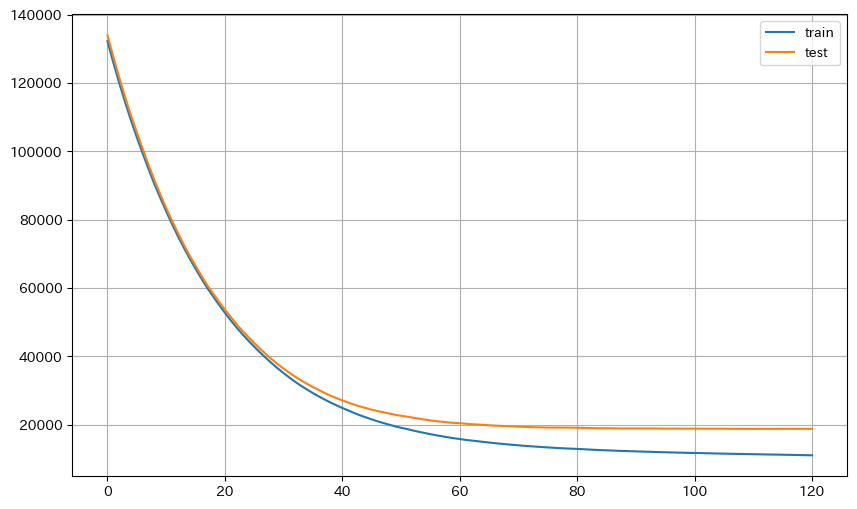

[14:14:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132931.10624	validation_1-rmse:131365.32919
[1]	validation_0-rmse:126621.35318	validation_1-rmse:125165.46746
[2]	validation_0-rmse:120637.72137	validation_1-rmse:119306.43162
[3]	validation_0-rmse:115001.26434	validation_1-rmse:113755.37585
[4]	validation_0-rmse:109644.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:90819.37947	validation_1-rmse:90251.80850
[9]	validation_0-rmse:86735.34651	validation_1-rmse:86300.38274
[10]	validation_0-rmse:82824.02269	validation_1-rmse:82467.87209
[11]	validation_0-rmse:79028.14489	validation_1-rmse:78768.05891
[12]	validation_0-rmse:75444.53184	validation_1-rmse:75299.64633
[13]	validation_0-rmse:72097.90994	validation_1-rmse:72062.69345
[14]	validation_0-rmse:68872.02286	validation_1-rmse:68958.59312
[15]	validation_0-rmse:65869.82360	validation_1-rmse:66067.53261
[16]	validation_0-rmse:62937.63618	validation_1-rmse:63259.06512
[17]	validation_0-rmse:60160.67645	validation_1-rmse:60604.87691
[18]	validation_0-rmse:57663.35963	validation_1-rmse:58209.25727
[19]	validation_0-rmse:55191.32379	validation_1-rmse:55849.79862
[20]	validation_0-rmse:52871.03403	validation_1-rmse:53644.60191
[21]	validation_0-rmse:50650.72066	validation_1-rmse:51596.25338
[22]	validation_0-rmse:48524.97076	validation_1-rmse:49615.53165
[23]	validation_0-rmse:4654

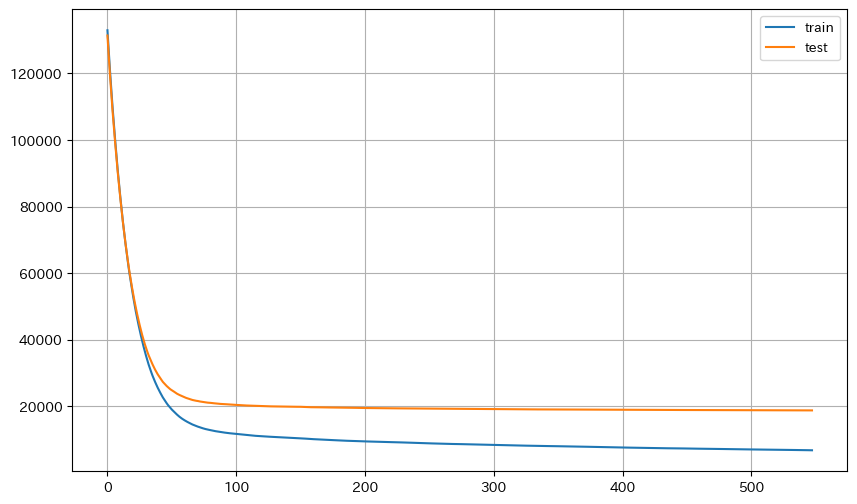

[14:14:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132216.84309	validation_1-rmse:134382.47790
[1]	validation_0-rmse:125967.86969	validation_1-rmse:128067.10119
[2]	validation_0-rmse:120015.89634	validation_1-rmse:122097.15052
[3]	validation_0-rmse:114424.31927	validation_1-rmse:116482.07464
[4]	validation_0-rmse:109096.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:90429.02893	validation_1-rmse:92469.97538
[9]	validation_0-rmse:86350.96407	validation_1-rmse:88352.77811
[10]	validation_0-rmse:82469.32673	validation_1-rmse:84524.43574
[11]	validation_0-rmse:78715.60593	validation_1-rmse:80729.02057
[12]	validation_0-rmse:75171.63297	validation_1-rmse:77229.72660
[13]	validation_0-rmse:71855.58880	validation_1-rmse:73998.85149
[14]	validation_0-rmse:68671.87791	validation_1-rmse:70788.45486
[15]	validation_0-rmse:65696.92526	validation_1-rmse:67841.19195
[16]	validation_0-rmse:62811.72254	validation_1-rmse:65037.25788
[17]	validation_0-rmse:60072.02416	validation_1-rmse:62311.43123
[18]	validation_0-rmse:57599.55676	validation_1-rmse:59963.31992
[19]	validation_0-rmse:55144.90512	validation_1-rmse:57565.70560
[20]	validation_0-rmse:52812.94770	validation_1-rmse:55304.19140
[21]	validation_0-rmse:50623.46899	validation_1-rmse:53187.70636
[22]	validation_0-rmse:48519.54150	validation_1-rmse:51161.84967
[23]	validation_0-rmse:4654

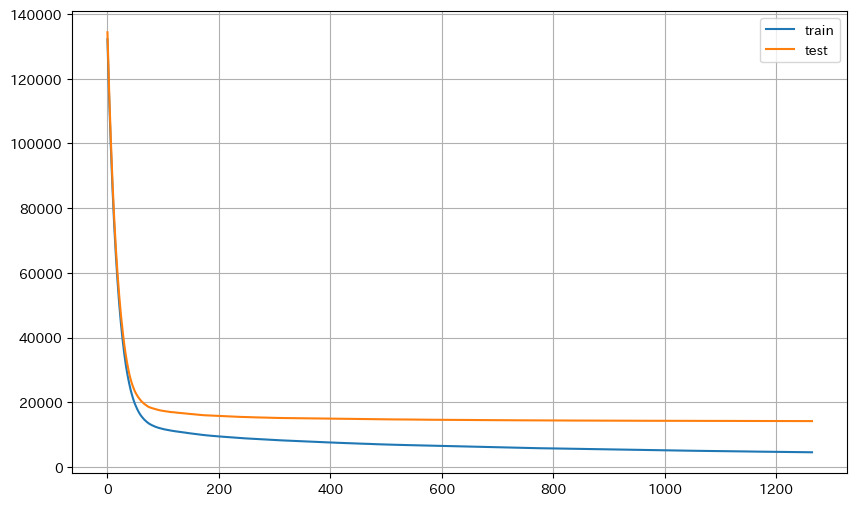

whole valid rmse: 17074.552544445076
Start predicting...


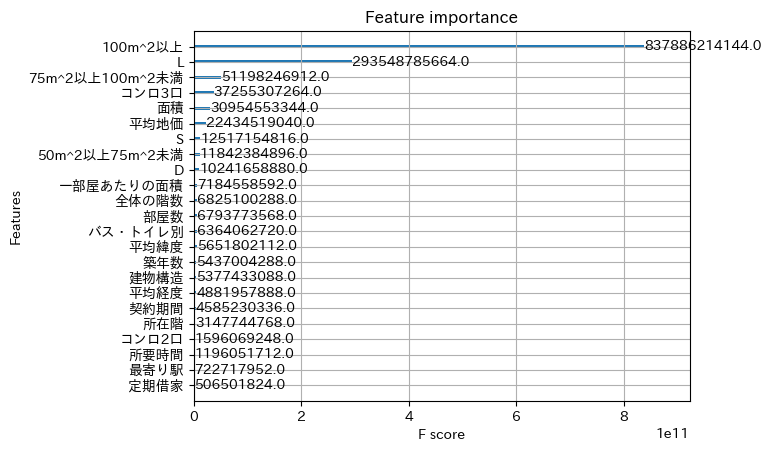

In [9]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    # 学習時に用いる検証用データ
    evals = [(X_tr, 'train'), (X_tr, 'eval')]
    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        # 回帰問題
                        objective='reg:linear',
                        # 学習用の指標 (RMSE)
                        eval_metric='rmse',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        #学習率
                        learning_rate=0.05,
                        #木の最大深さ
                        max_depth=7,
                        #シード値
                        random_state=0,
                            #正則化
                        reg_alfa=6.8594164113286965e-06,

                        sub_sample=0.16056047423047484,

                        colsample_bytree=0.6987351856651322,

                        min_child_weight=1.1103525577197584,
                        
                        evals=evals,

                        evals_result=evals_result
    )
    xgb_reg.fit(X_tr, y_tr, 
                eval_set=[(X_tr, y_tr),(X_val, y_val)], 
                early_stopping_rounds=10, 
            )
    evals_result = xgb_reg.evals_result()
    train_evals = evals_result['validation_0']['rmse']
    test_evals = evals_result['validation_1']['rmse']

    pred_y_val = xgb_reg.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

    # 学習の課程を折れ線グラフとしてプロットする
    print('Plot metrics during training...')
    plt.figure(figsize=(10, 6))
    plt.subplot(111)
    x = range(len(train_evals))
    plt.plot(x, train_evals, label='train')
    plt.plot(x, test_evals, label='test')
    # plt.plot(x, ave_cv_evals, label='validation')
    plt.grid()
    plt.legend()
    plt.show()

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = xgb_reg.predict(X_test)

# feature importanceを表示
xgboost.plot_importance(xgb_reg, importance_type = "gain")
plt.show()

In [13]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/XGB_cv_result.csv',index=False)